In [ ]:
# Scripting with Bokeh & Holoviews

In [1]:
# Initializing
import sys
from pathlib import Path
sys.path.insert(0, str((Path().home()/"trackanalysis")/"build"))

from scripting import *

from matplotlib import rcParams
rcParams['figure.figsize'] = 12, 8

/home/pol/miniconda3/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
track = Track(path = "/home/pol/Documents/tracks/AT_CG_AC_TC_43-1.trk")
meas  = track.measures[15,7][300:510]

# Bokeh Examples

Module 'trackanalysis.scripting.curve' adds some syntactic sugar to Bokeh. It is imported using

    from scripting import *

## Curve:

    # adding a blue line on the left axis
    curve(data, color = 'blue', **bokeh_kwargs) 
    # adding a (default) red line on the right axis
    curve(data, axis = 'y', **bokeh_kwargs)

This adds a line to the plot with indices on the x-axis. Specifying axis allows displaying a right (='y') or top (='x') axis.

## Show:

Calling *show* simply displays the created plot. It's the endpoint.

## Together:

Curves are multiplied together in order to set them to the same plot. This is similar to what holoview does.

In [ ]:
# initializing bokeh
from bokeh.io import output_notebook
output_notebook()

In [3]:
(curve(meas)
 *rcurve(np.abs(track.events.events.split.deltas(meas)))
 *show())

In [6]:
(curve(meas)
 *rcurve(pd.Series(meas).rolling(5).std())
 *show())

In [16]:
from eventdetection.detection import SplitDetector
make = lambda x, y: rcurve(SplitDetector(window = x).deltas(meas),
                           color = y)
curve(meas)*make(1,'green')*make(2,'red')*make(3,'gray')*show()

In [3]:
delta = lambda x: ((pd.Series(meas).rolling(x).max().shift(-x)
                   -pd.Series(meas).rolling(x).min()<-2e-3)*1.)
a = delta(4)
for i in range(5,7):
    a += delta(i)
                   
#(0.2*a).diff()[300:480].plot()

aa = np.copy(meas)
aa[(0.2*a)>.5] = np.NaN

curve(meas)*rcurve(a)*curve(aa, color = 'orange')*show()

# Holoview Examples

This external library allows displaying multiple plots together

In [ ]:
#initializing holoviews
import holoviews as hv
hv.notebook_extension()
%output size=400

b':HoloMap   [cycles]\n   :Curve   [x]   (y)'
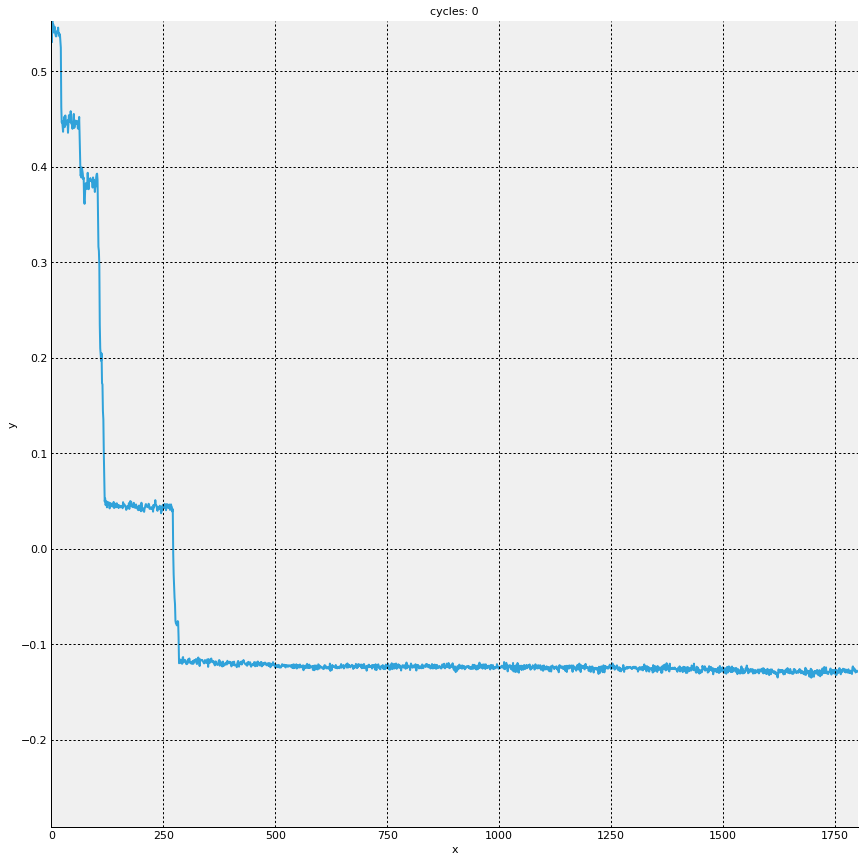
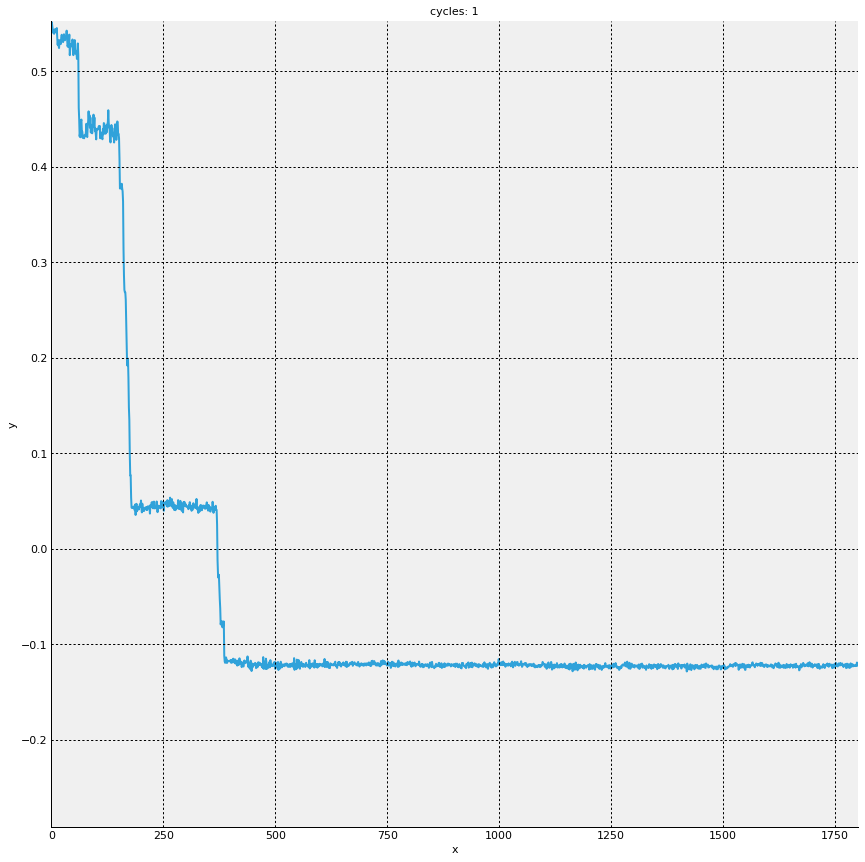
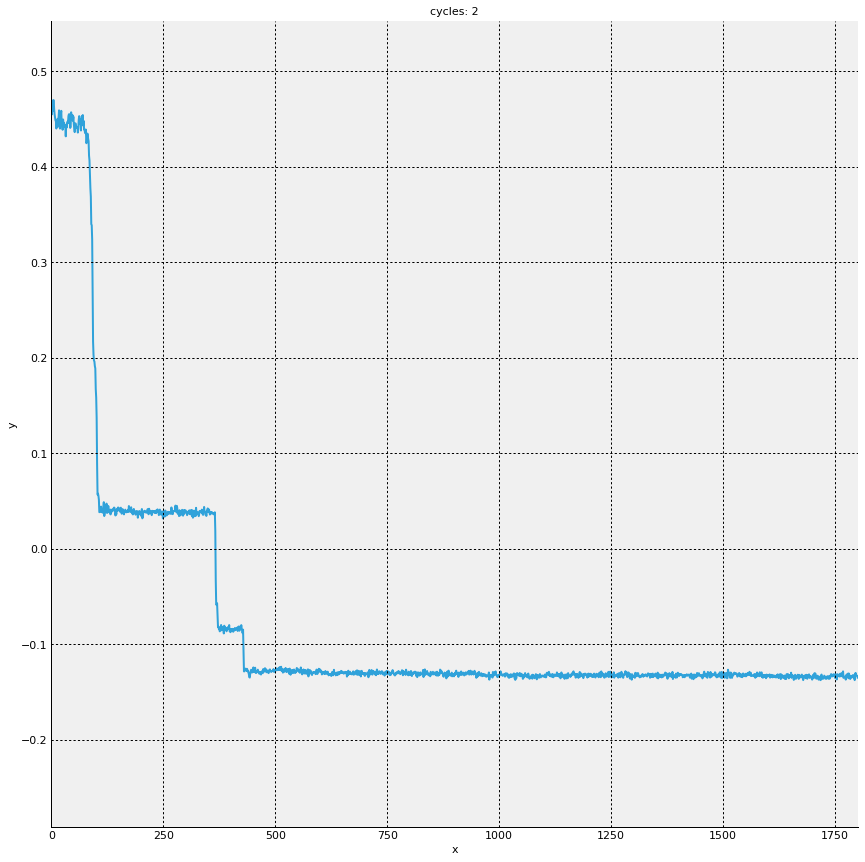
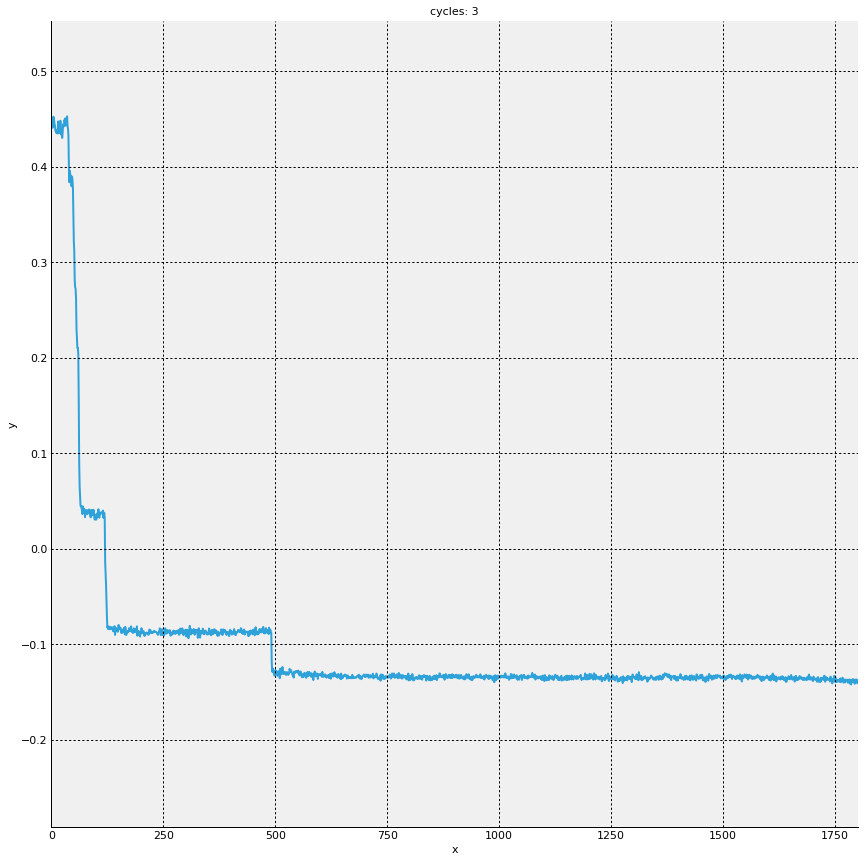
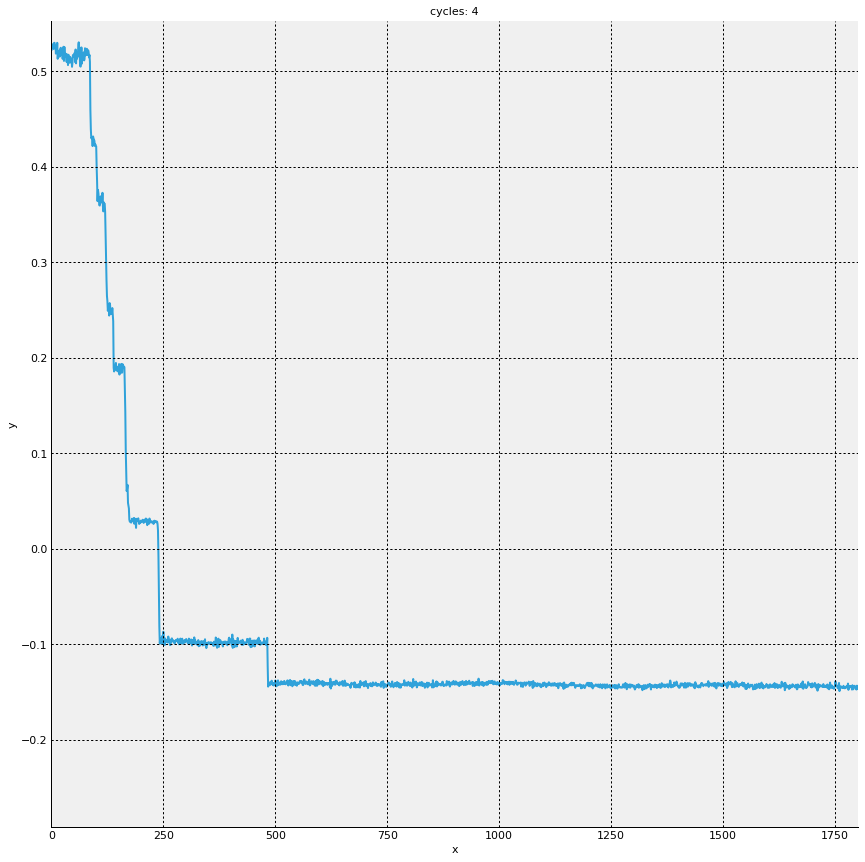
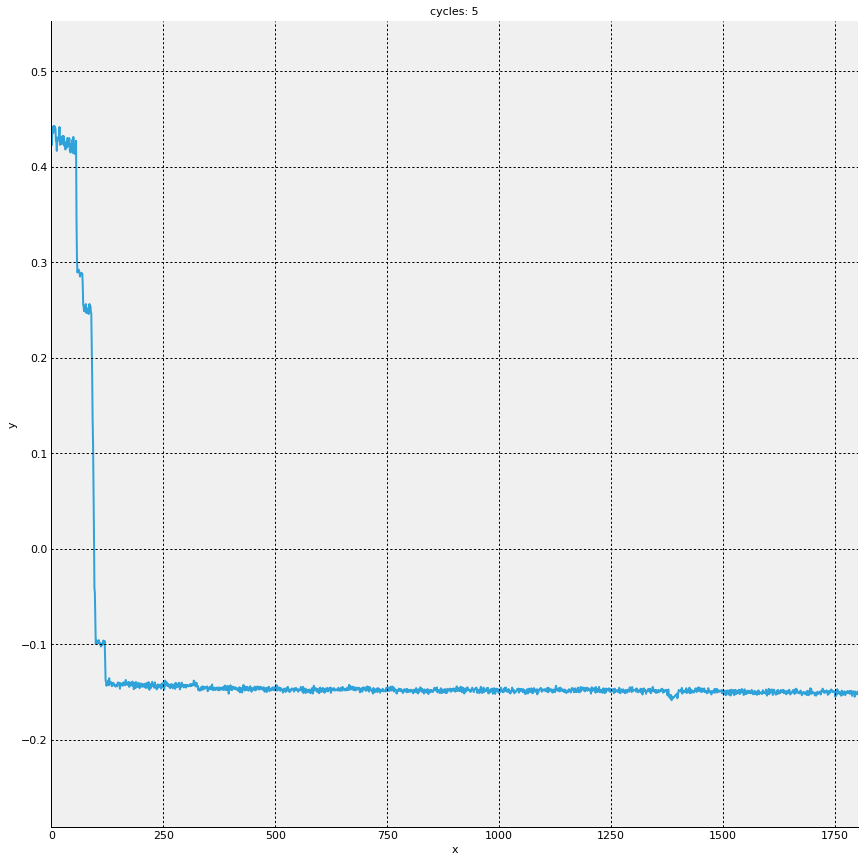
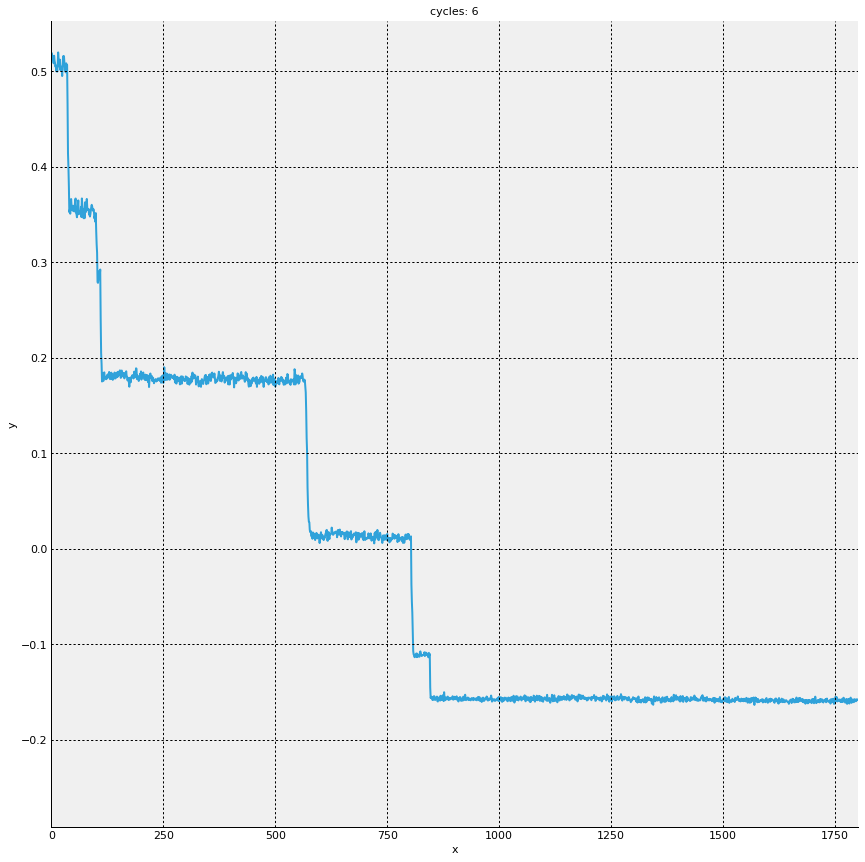
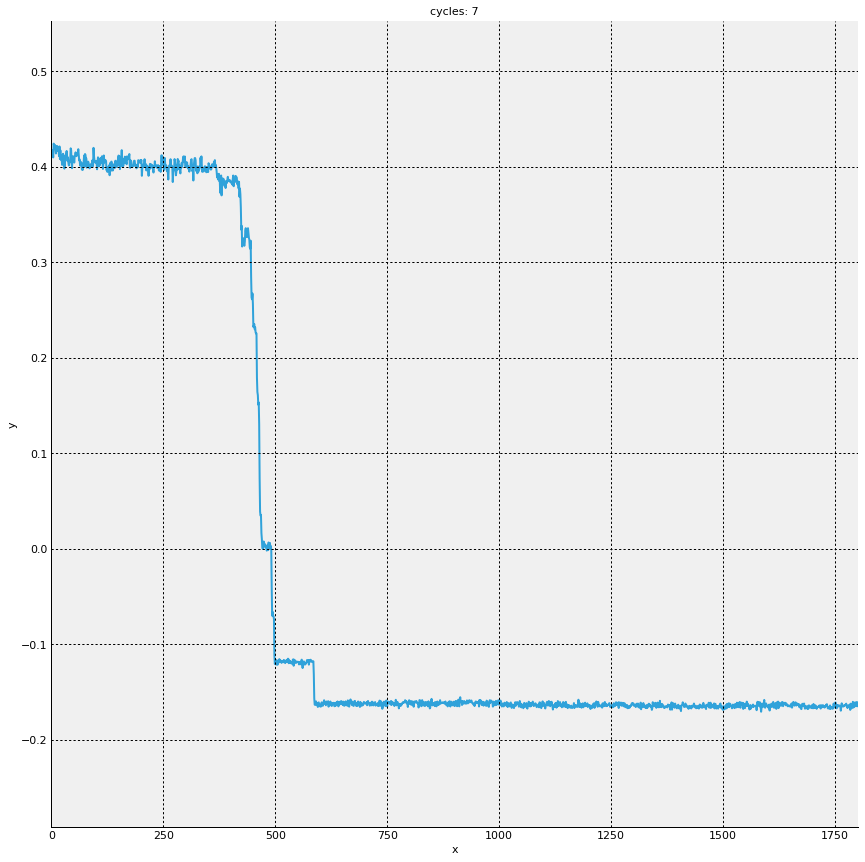
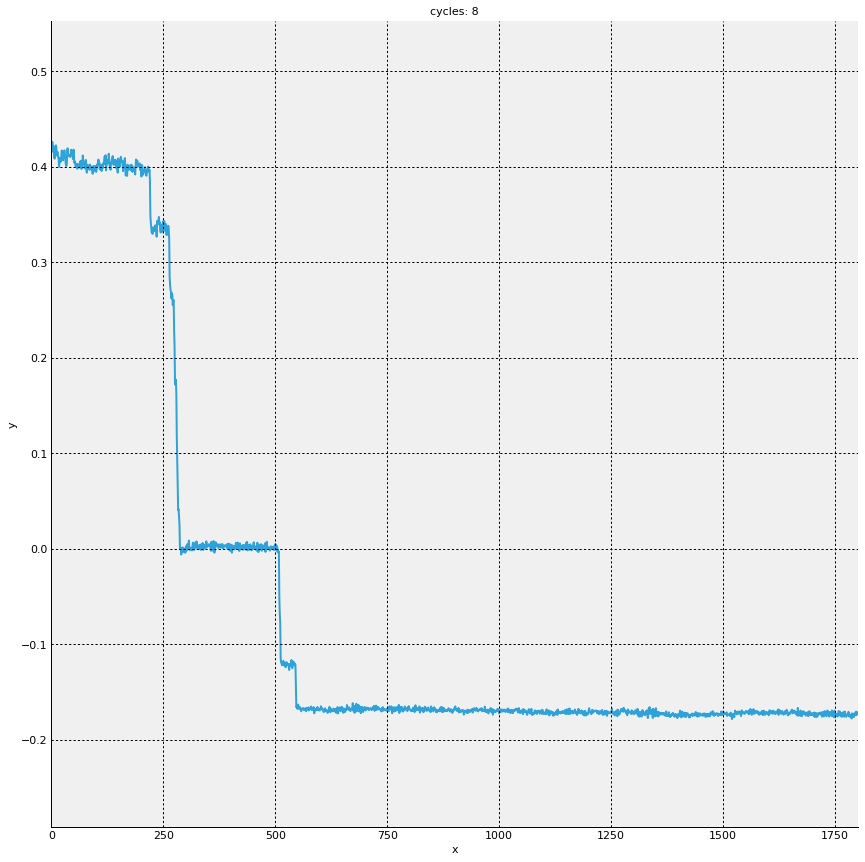
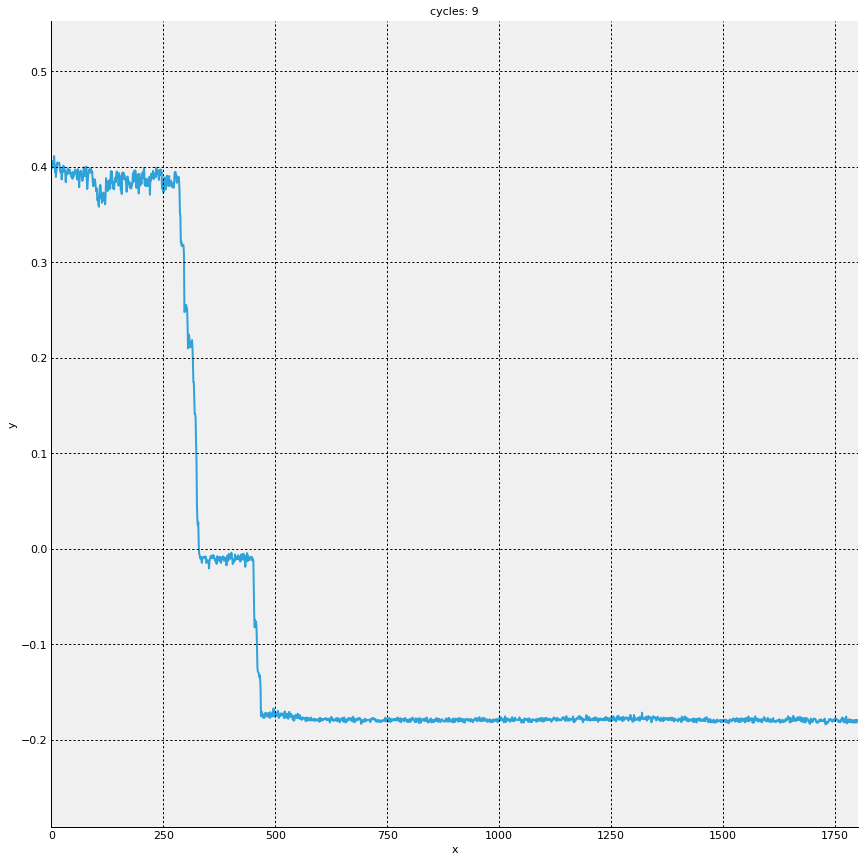
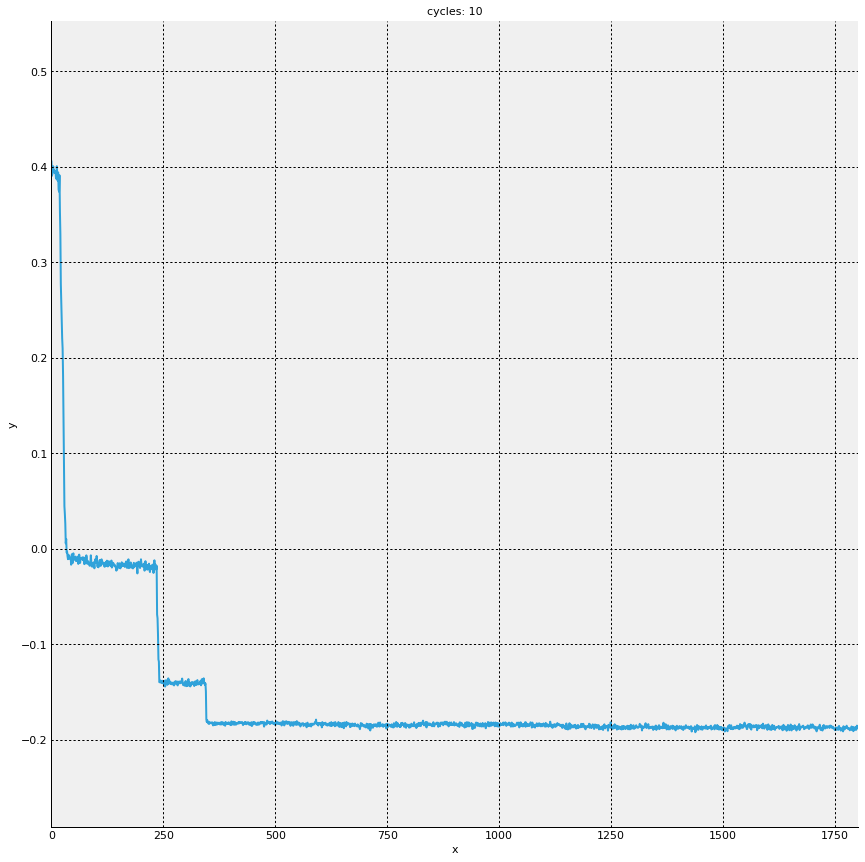
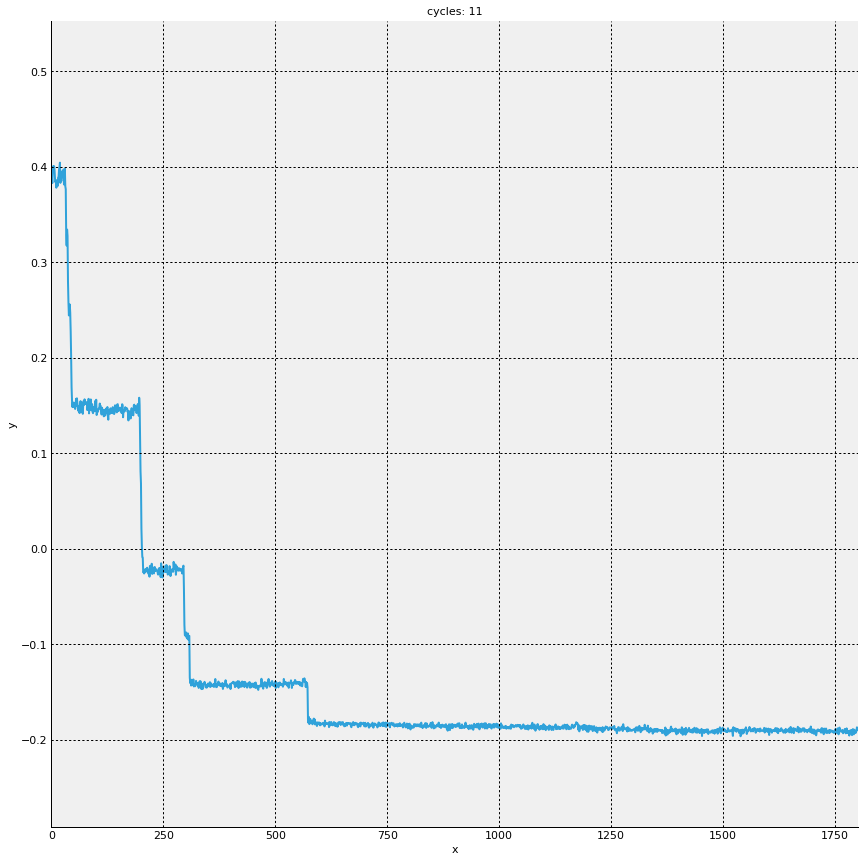
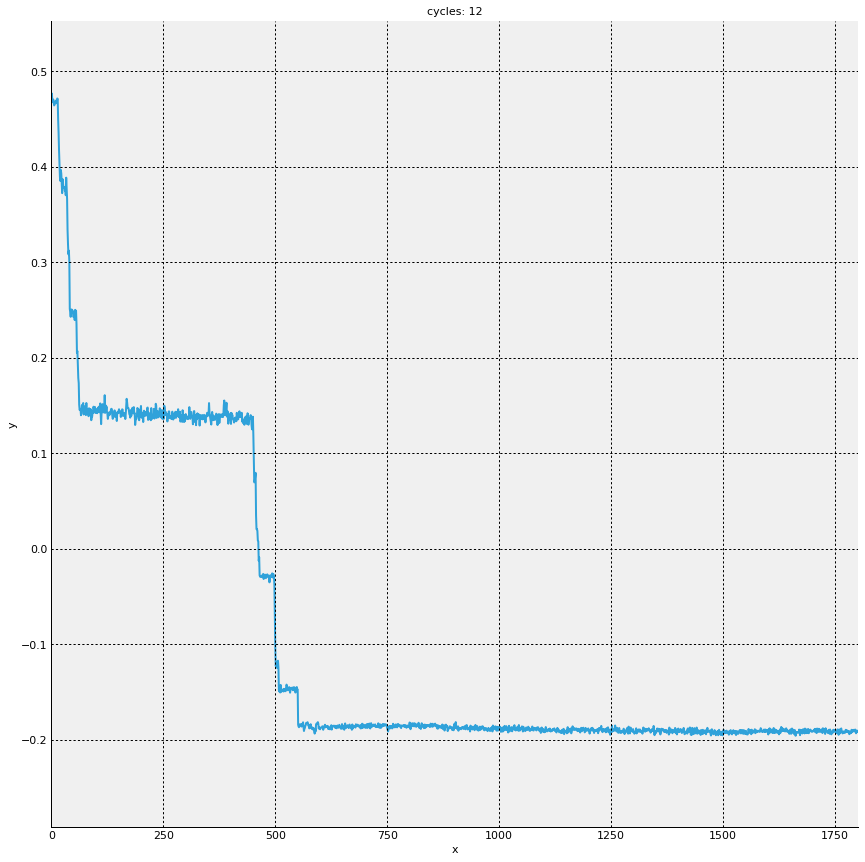
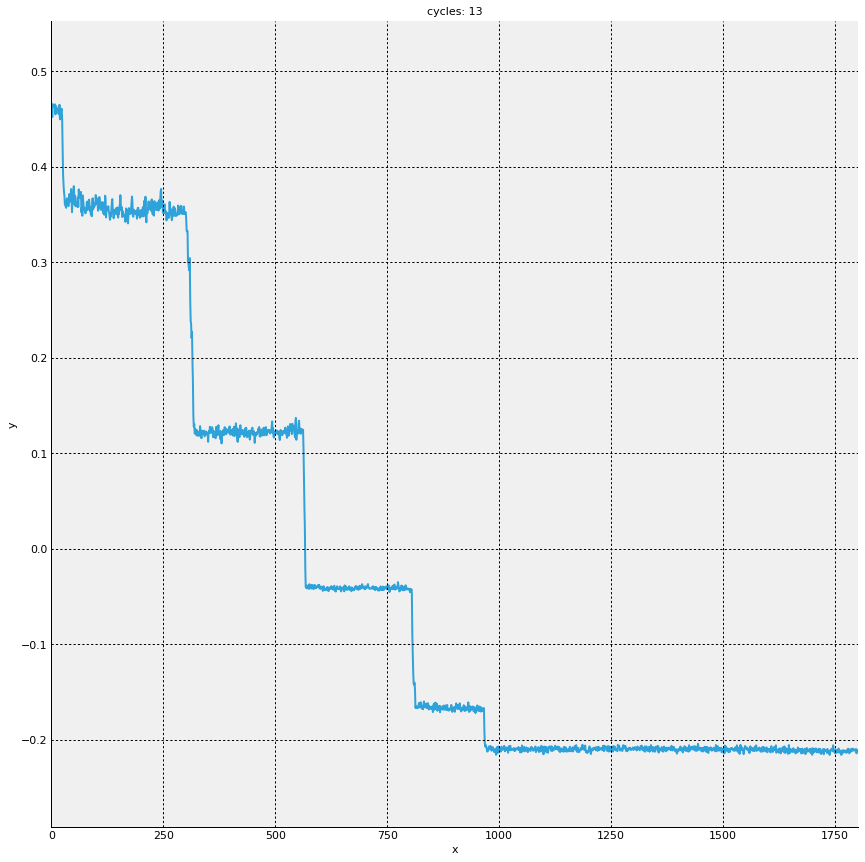
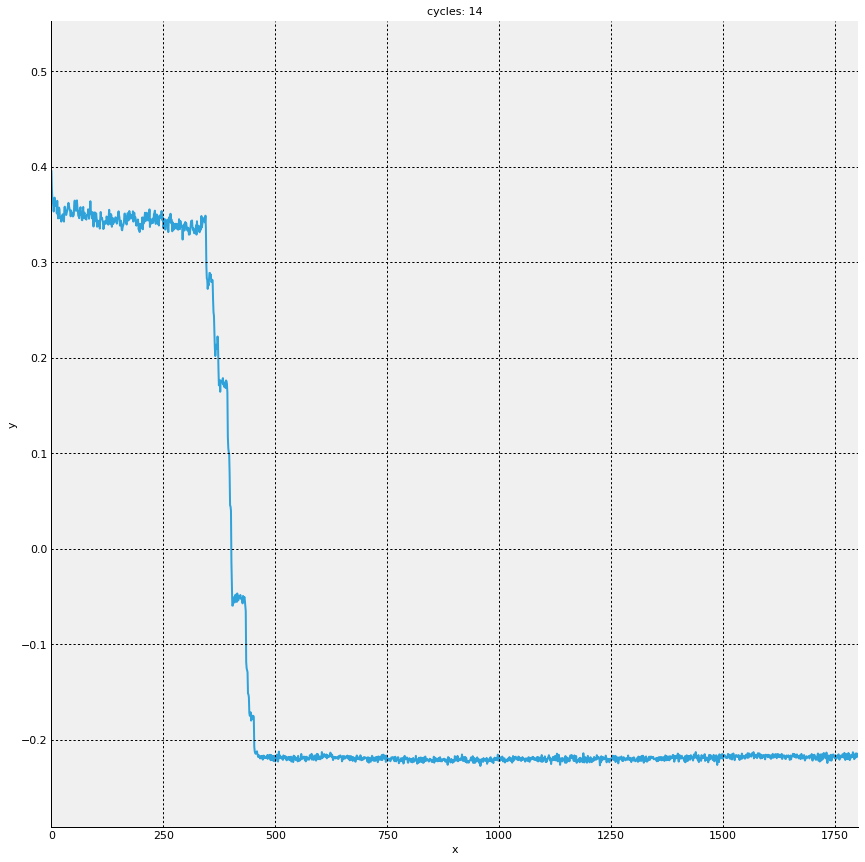
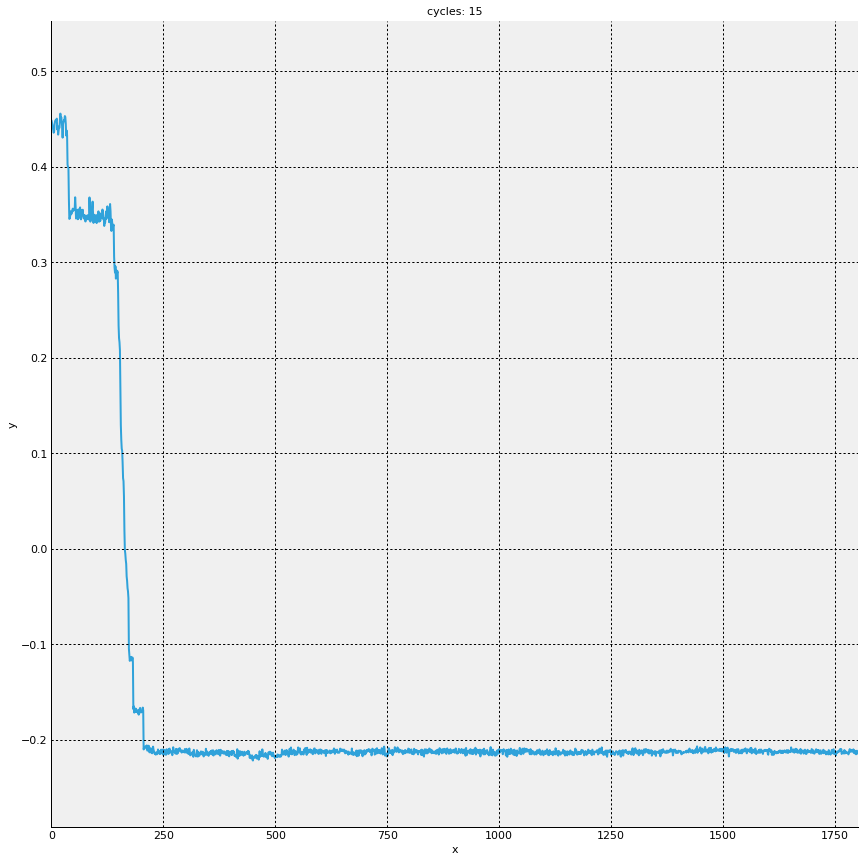
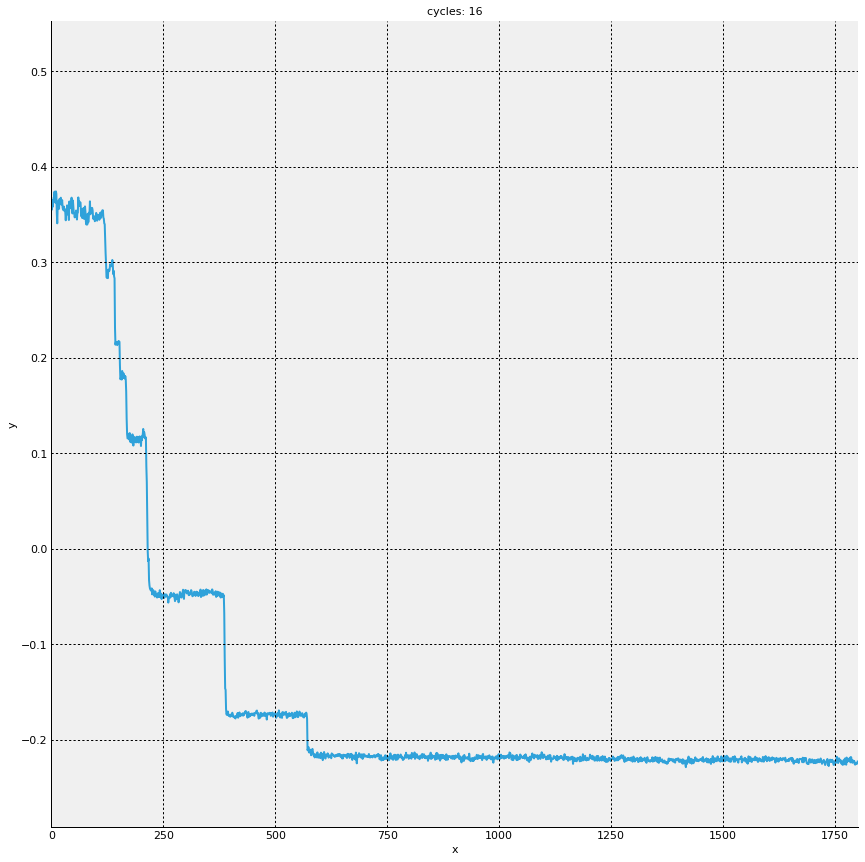
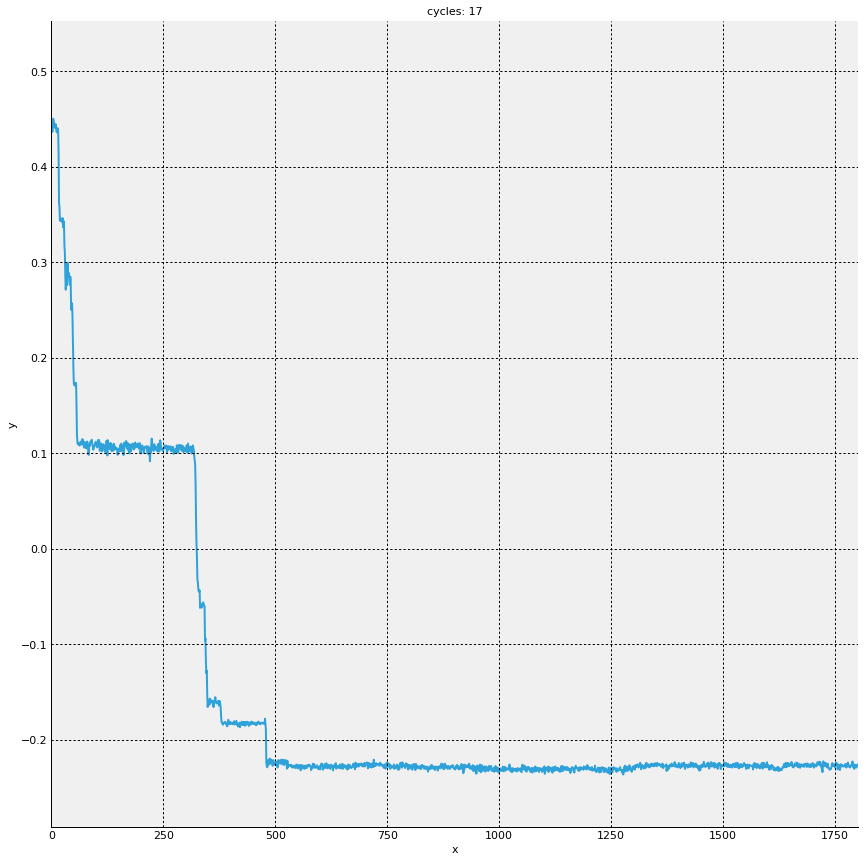
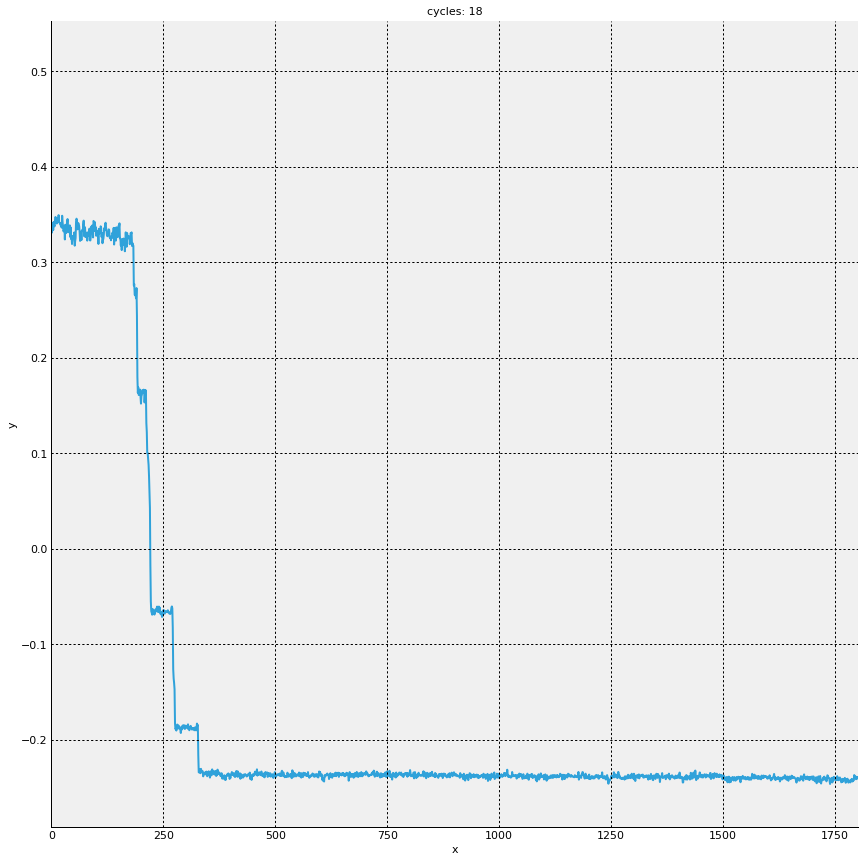
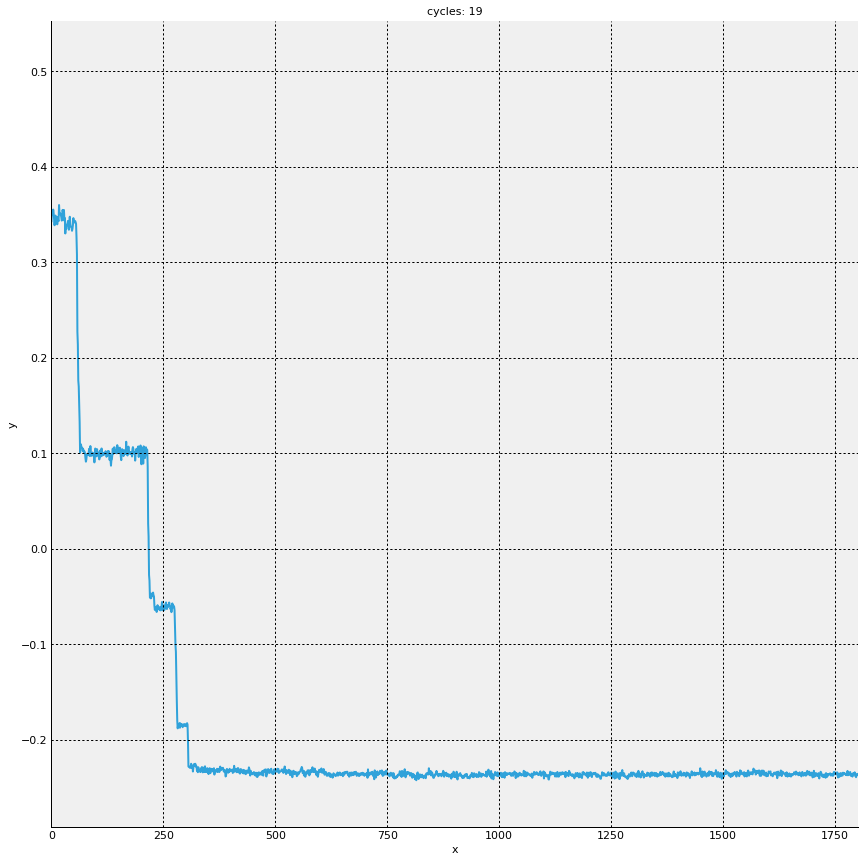
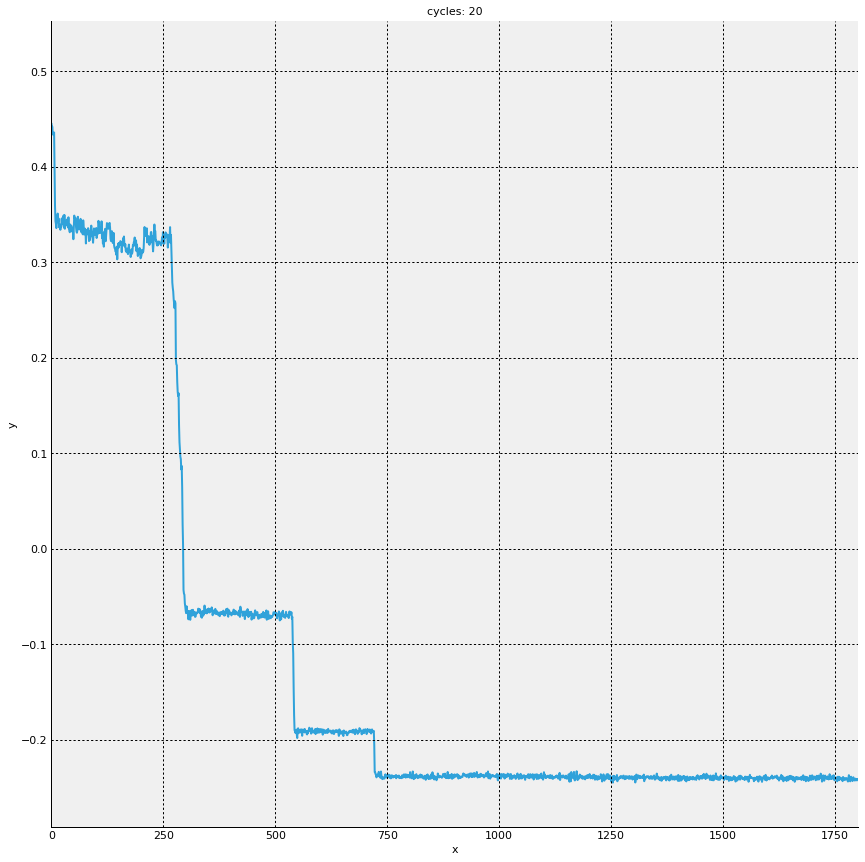
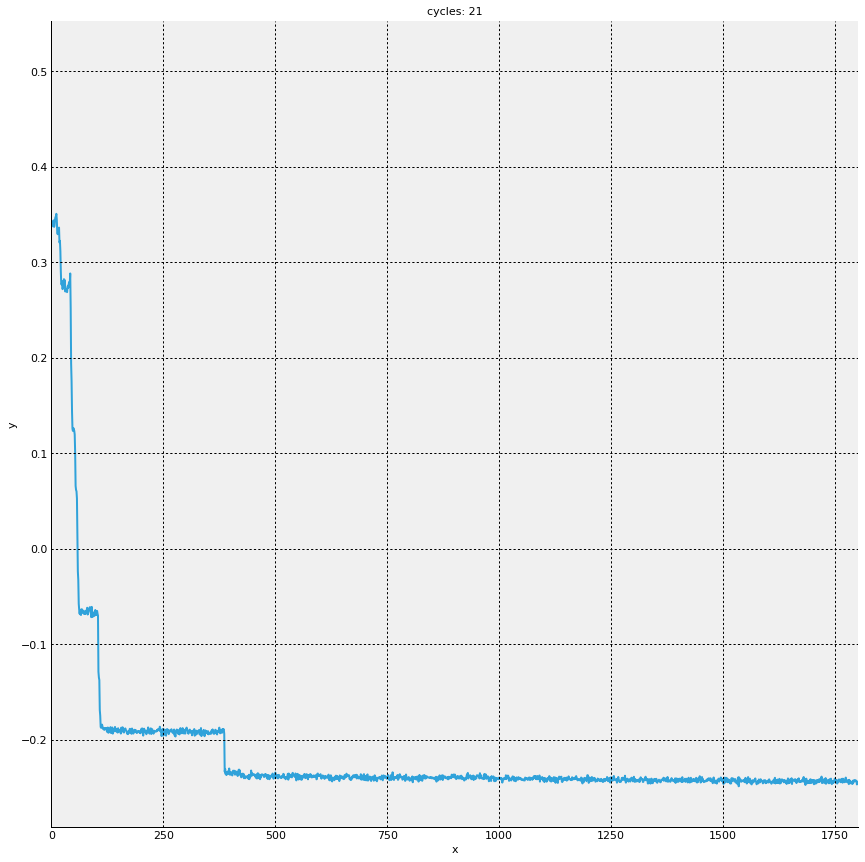
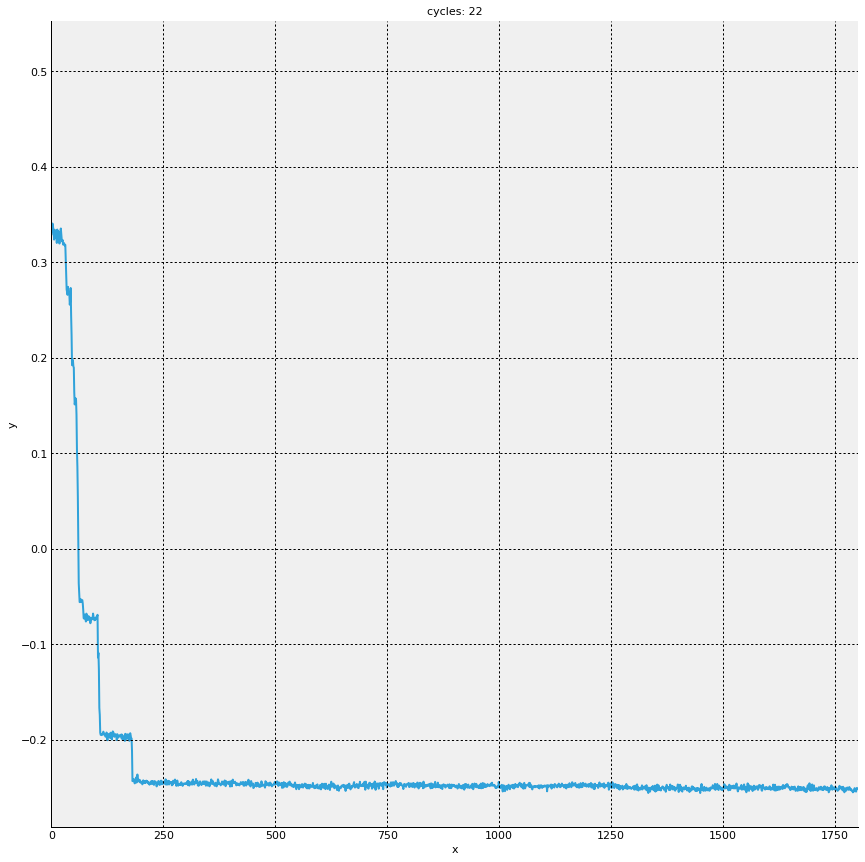
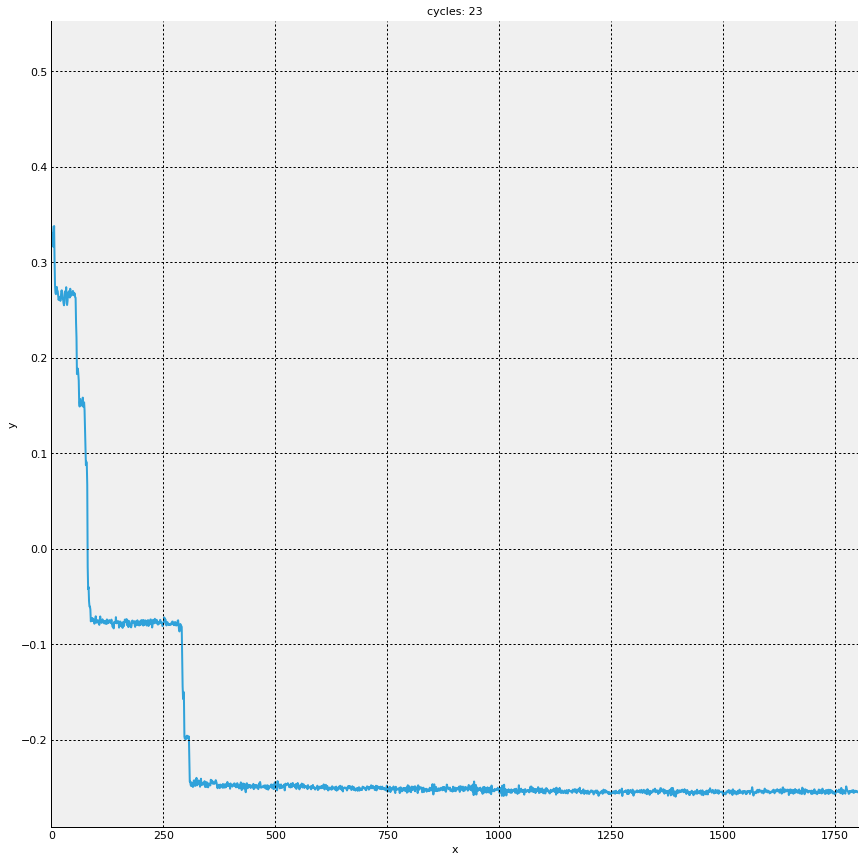
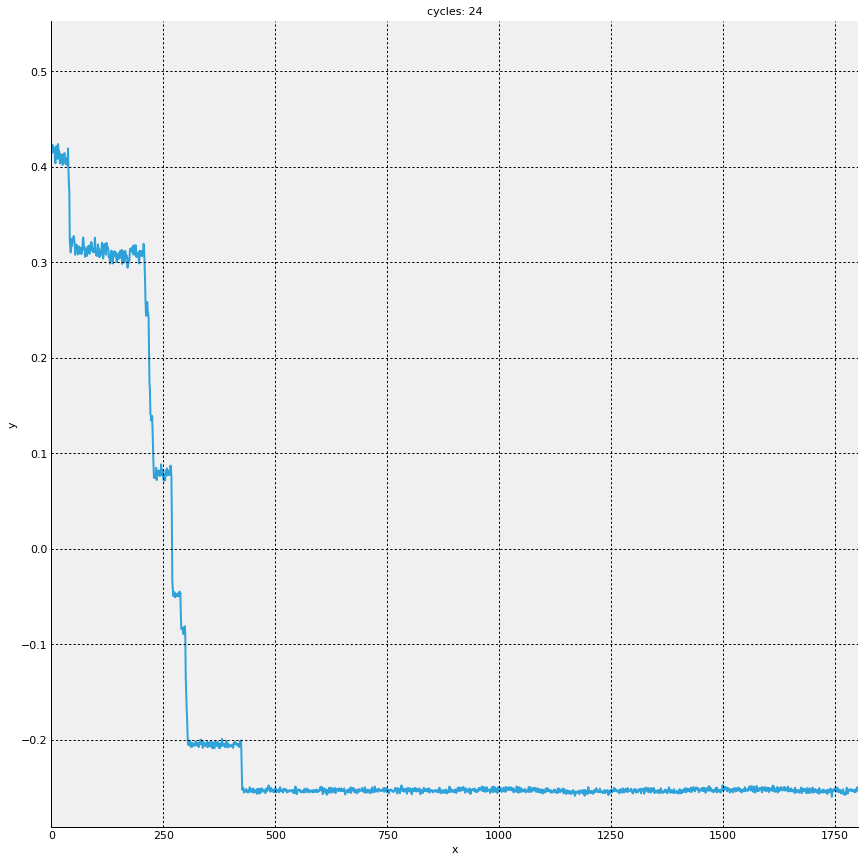
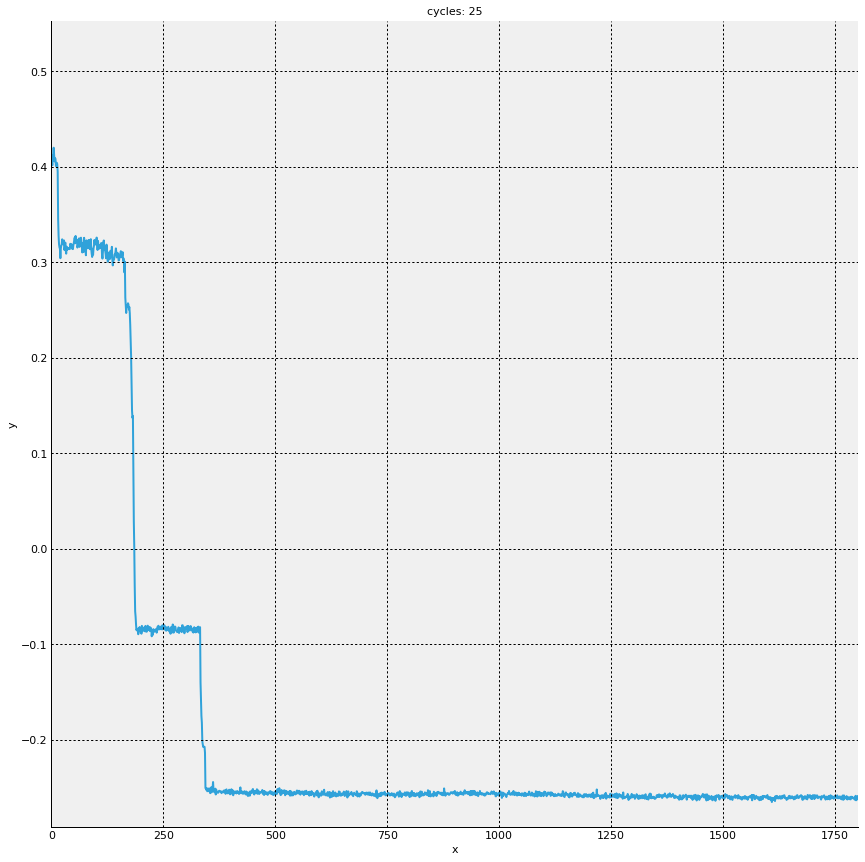
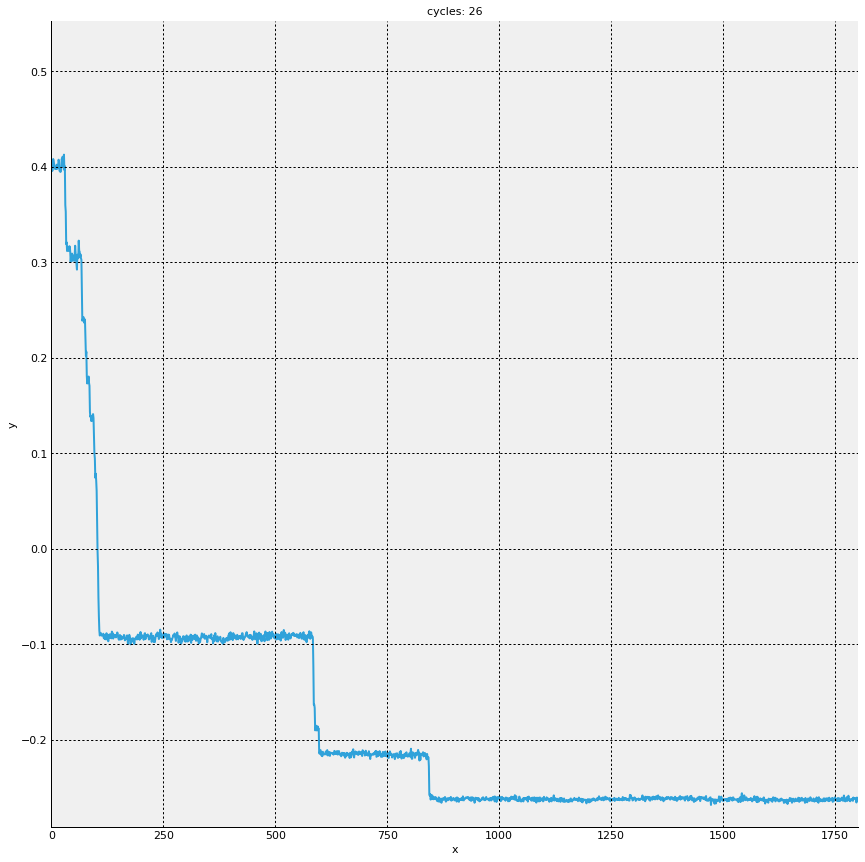
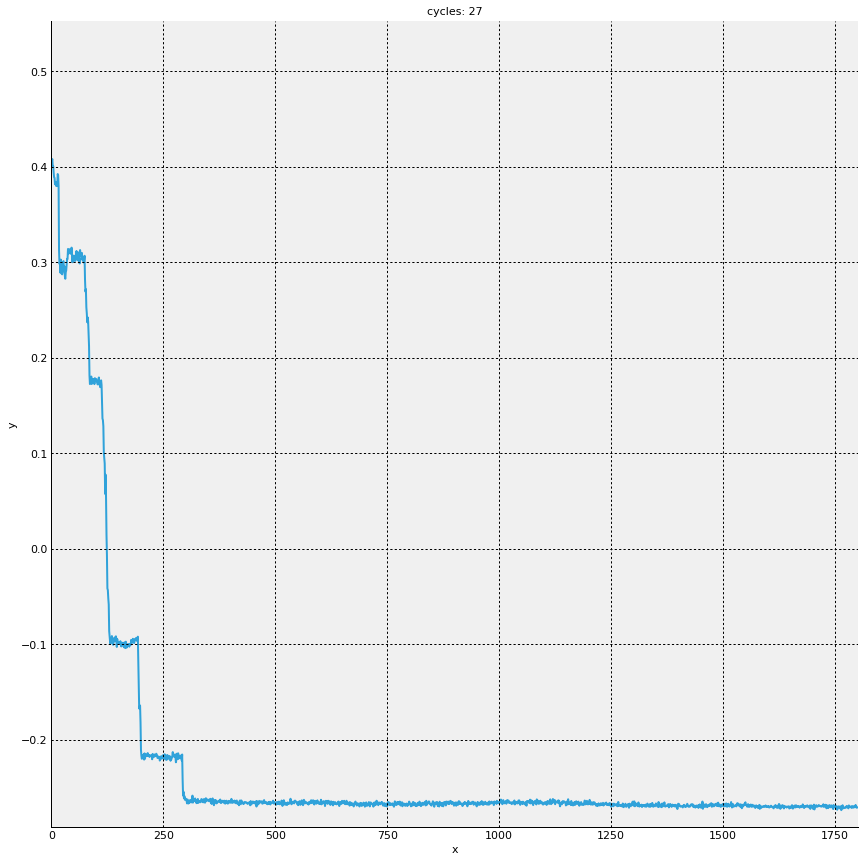
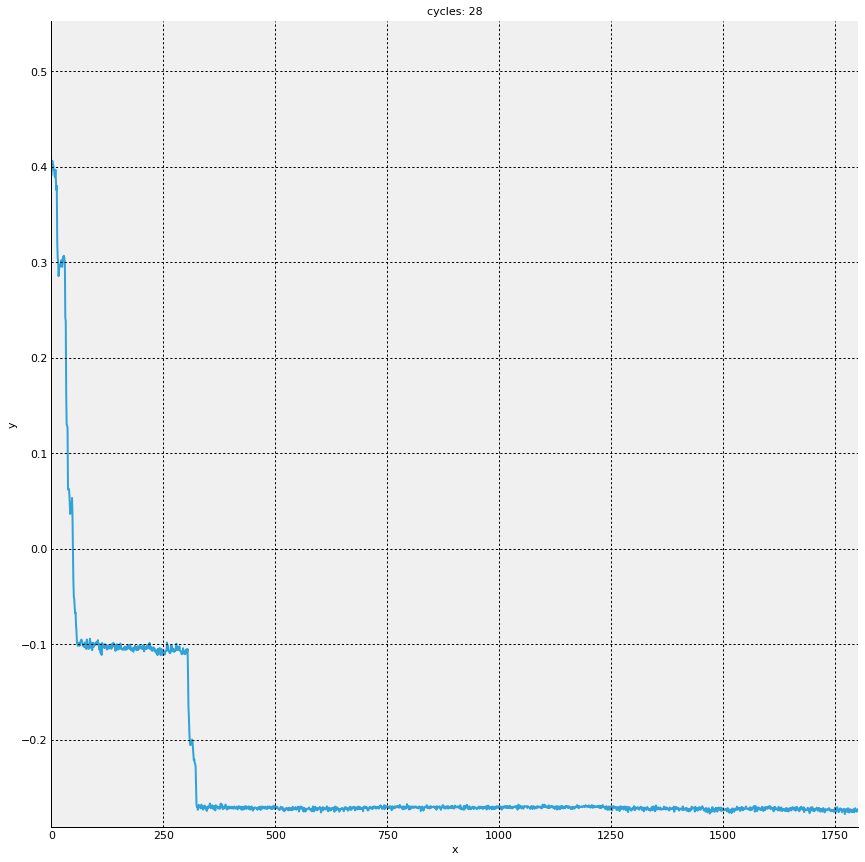
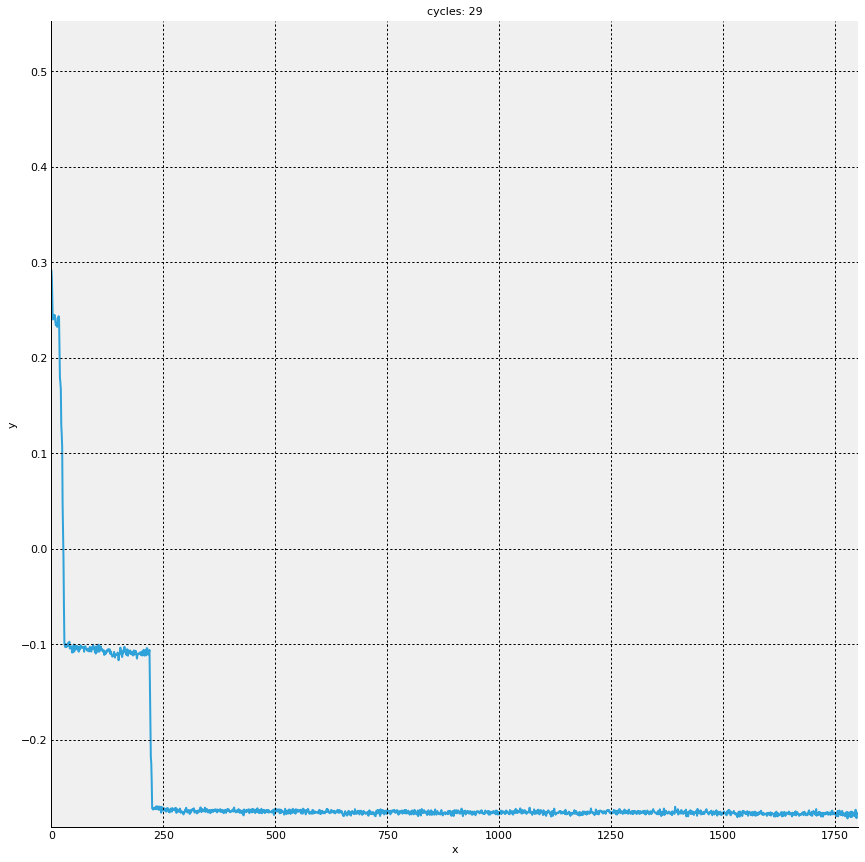
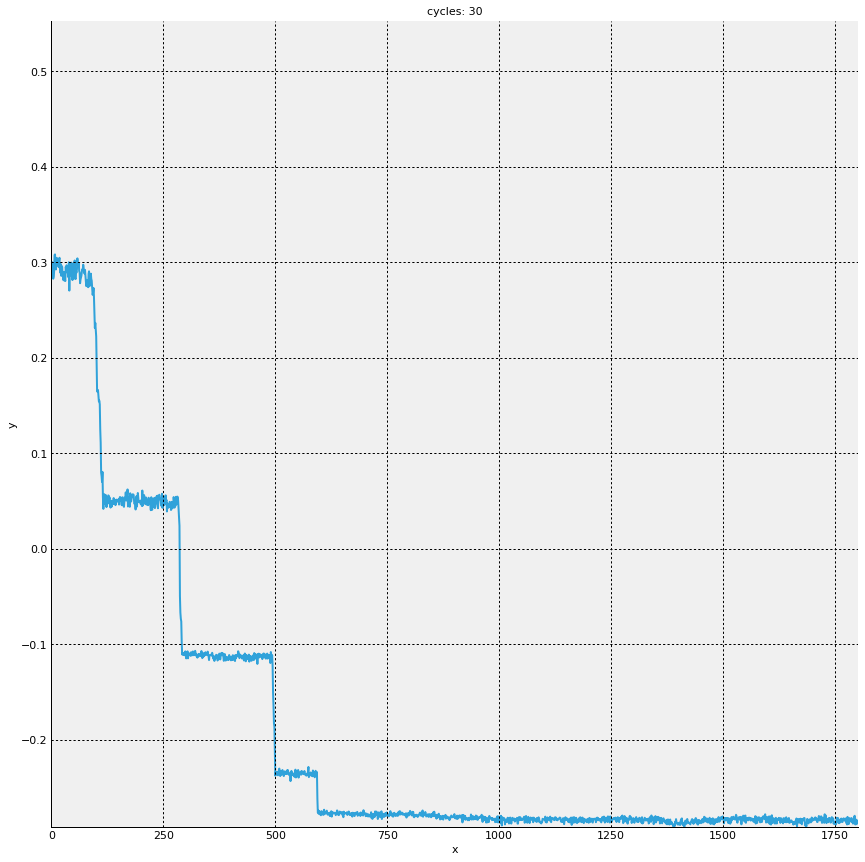
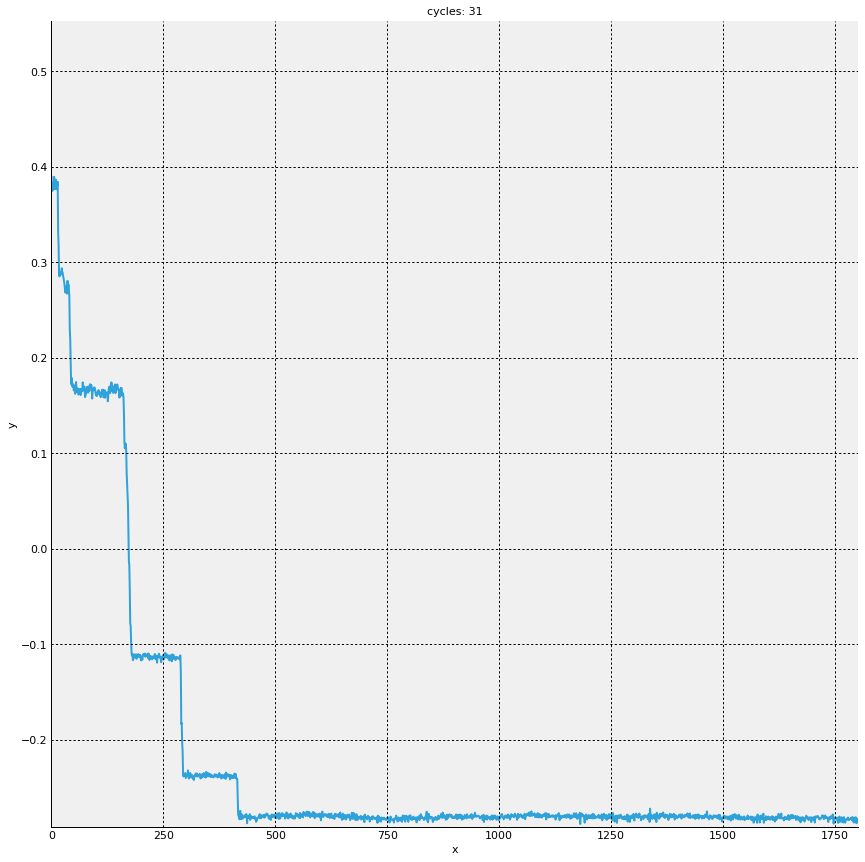

In [16]:
mp = hv.HoloMap(kdims = ['cycles'])

# Selecting phase 5 and bead 15 only
mp.update({i[1]: hv.Curve(j) for i, j in track.measures[15,...]})

mp

In [32]:
# Selecting phase 5, bead 15 and samples upt to 1000 
measures = track.measures[15,...].withsamples(slice(0,1000))

def computedelta(dt):
    def _comp(x):
        val = pd.Series(dt).rolling(x)
        return ((val.max().shift(-x)-val.min()) < -2e-3)*1.
    rng = iter(range(4,7))
    ret = _comp(next(rng))
    for i in rng:
        ret += _comp(i)
    return ret

def plotter(dt):
    vals   = computedelta(dt)
    bad    = vals >= np.max(vals)-.1
    orange = np.copy(dt)
    orange[bad] = np.NaN
    
    #vals  *= (np.max(dt)-np.min(dt))/np.max(vals)
    #vals  += np.min(dt)
    return hv.Curve(dt)*hv.Curve(orange)#*hv.Curve(vals)

b':HoloMap   [cycles]\n   :Overlay\n      .Curve.I  :Curve   [x]   (y)\n      .Curve.II :Curve   [x]   (y)'
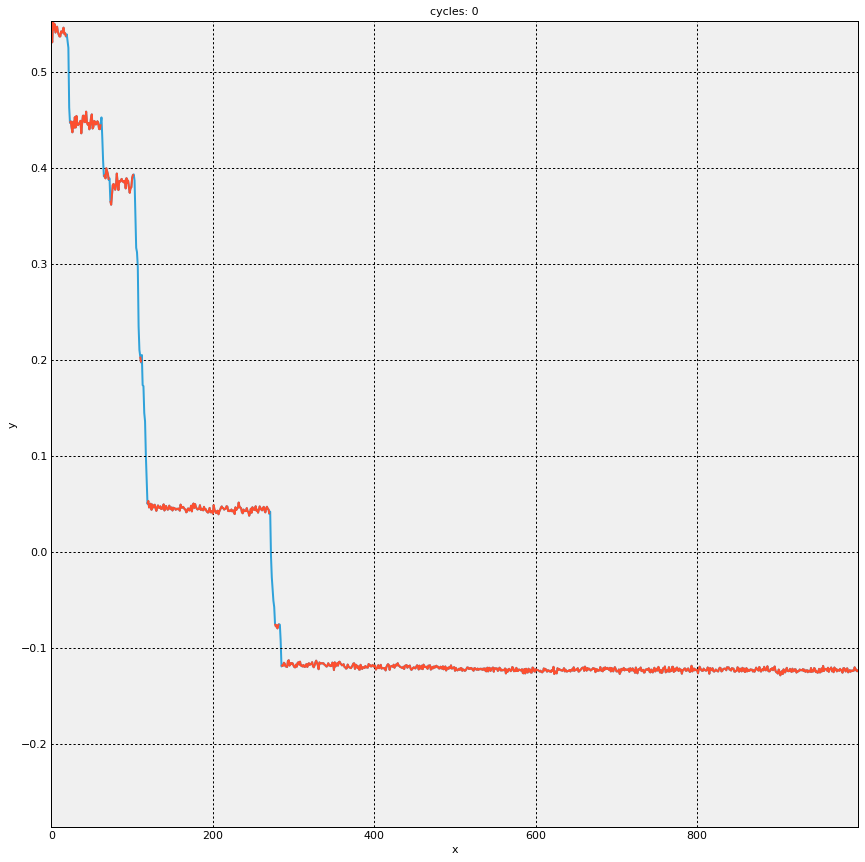
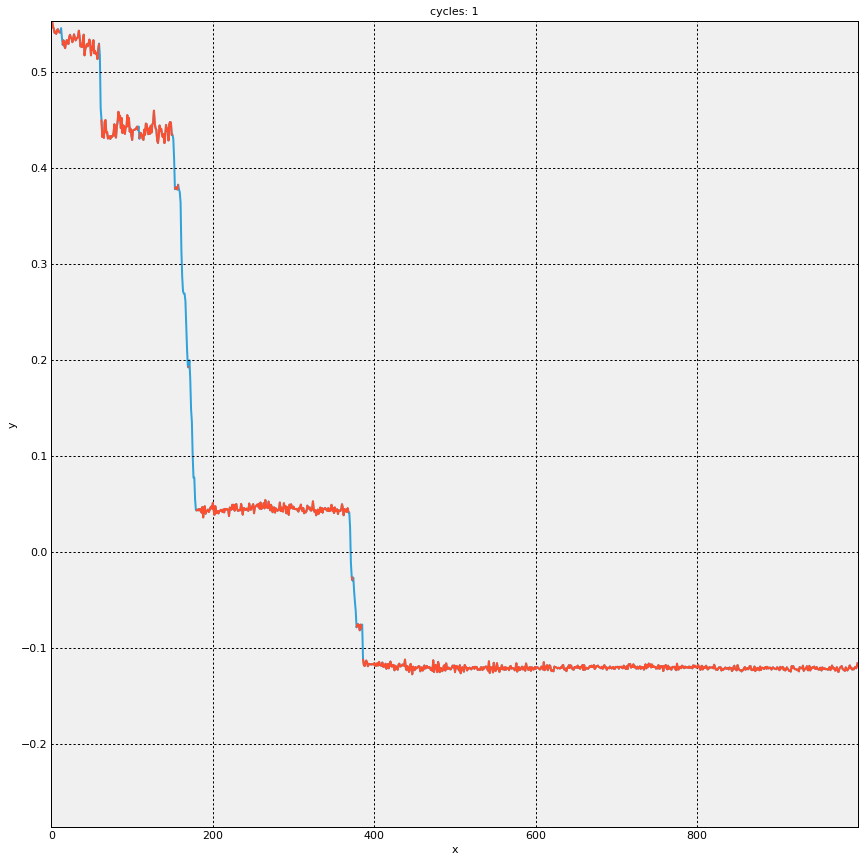
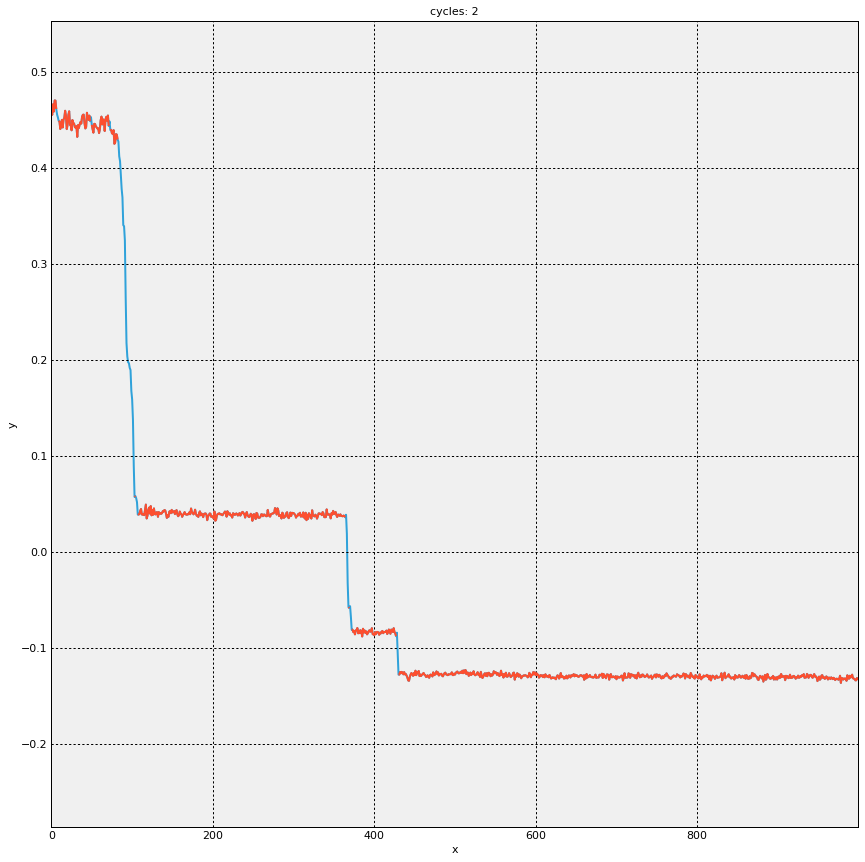
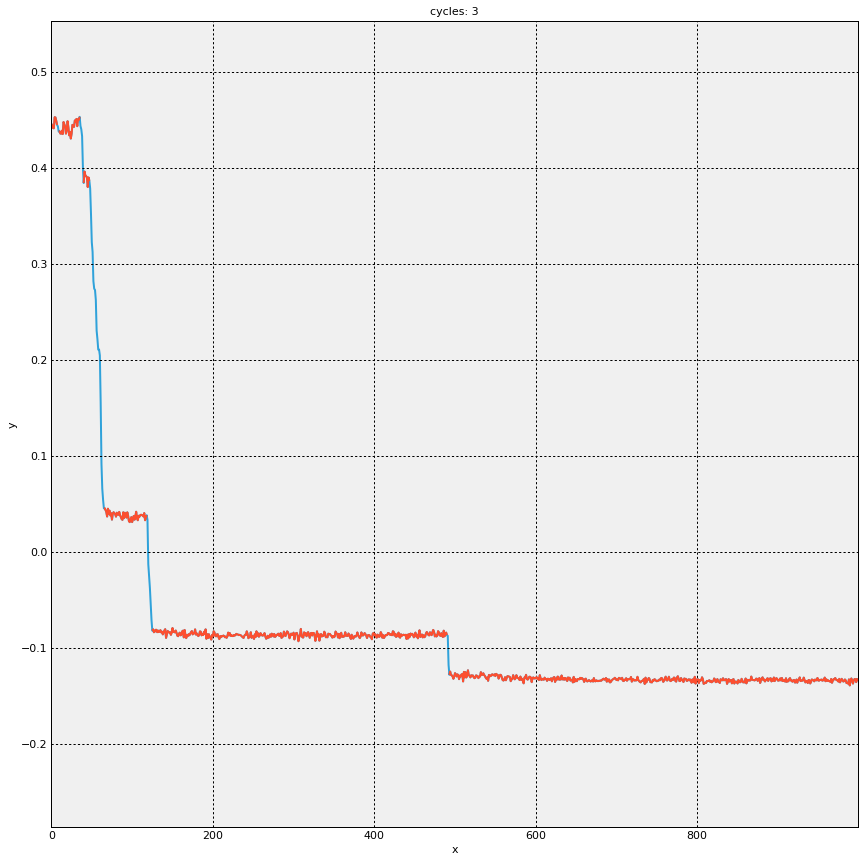
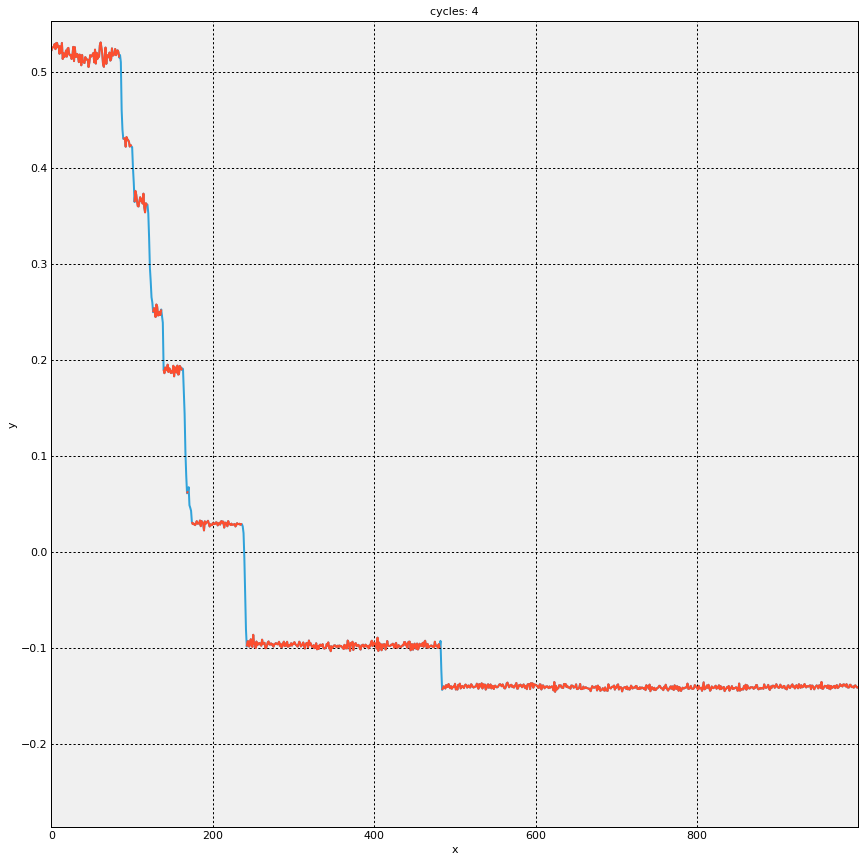
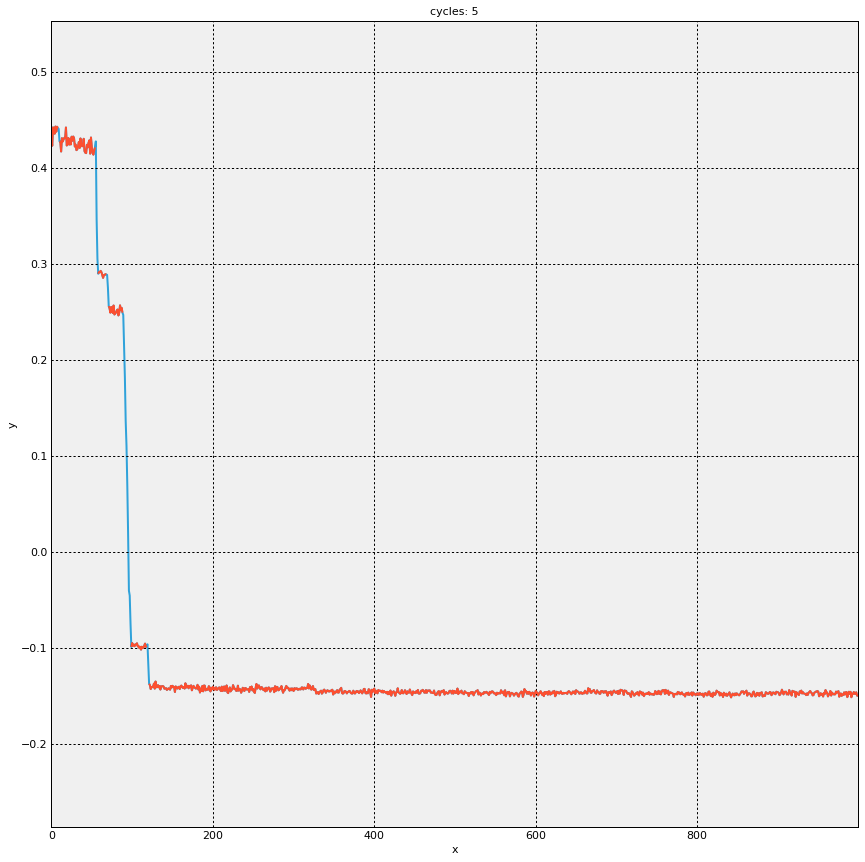
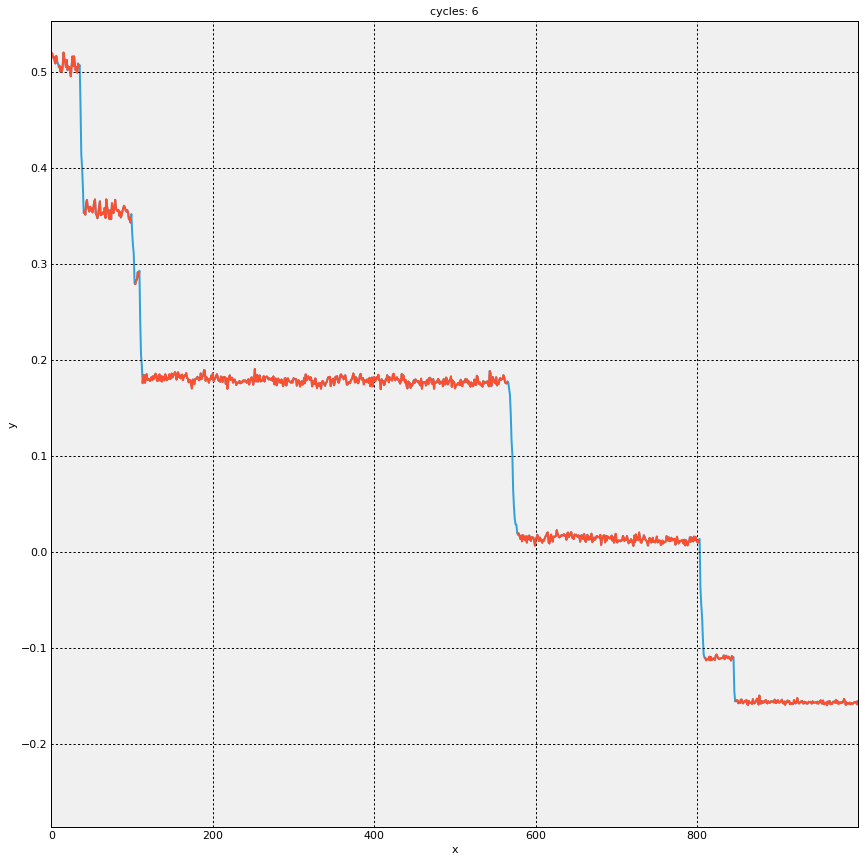
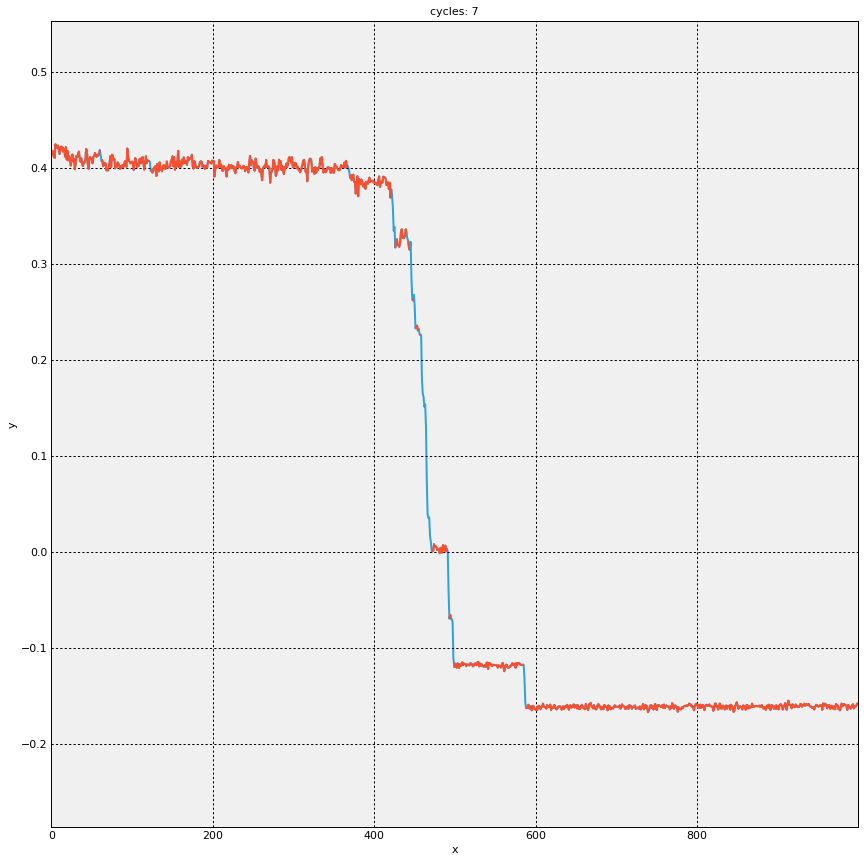
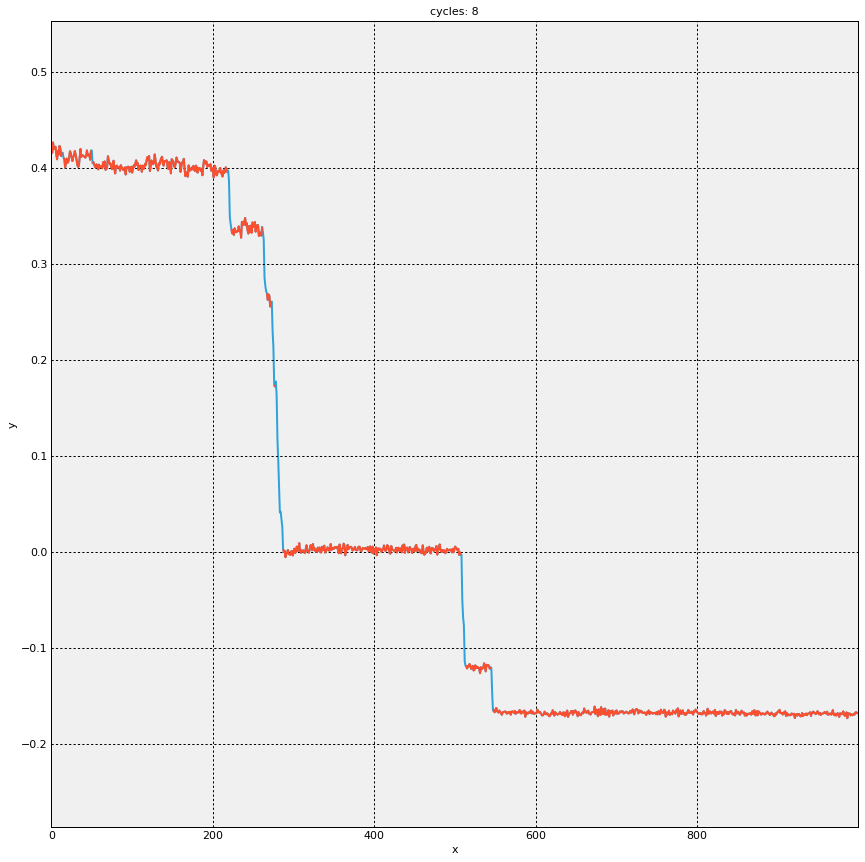
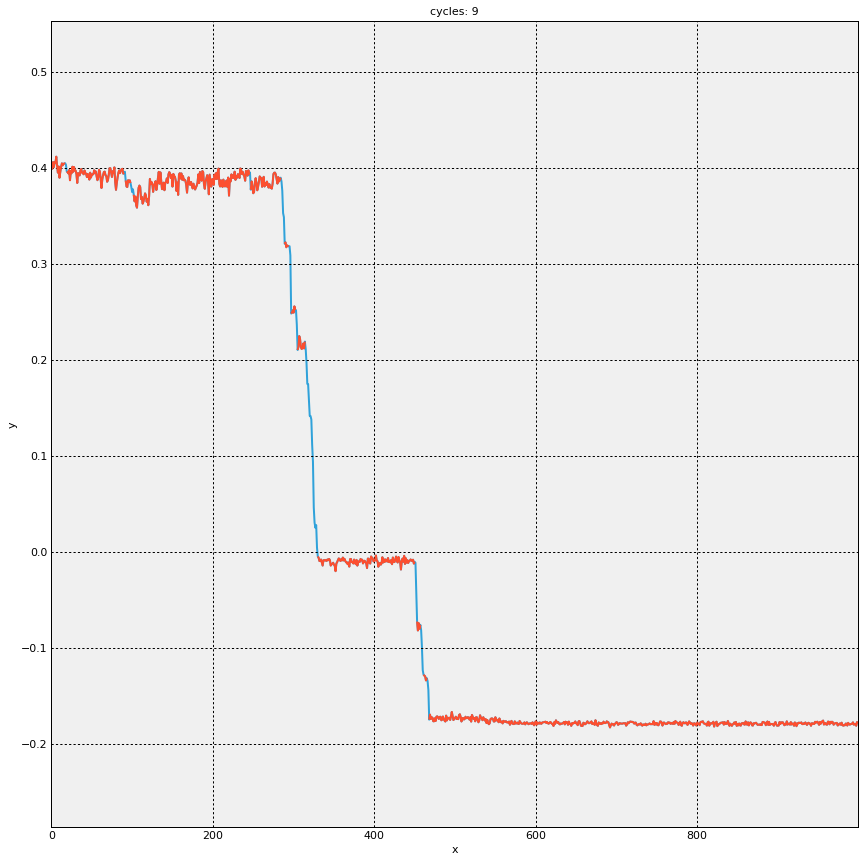
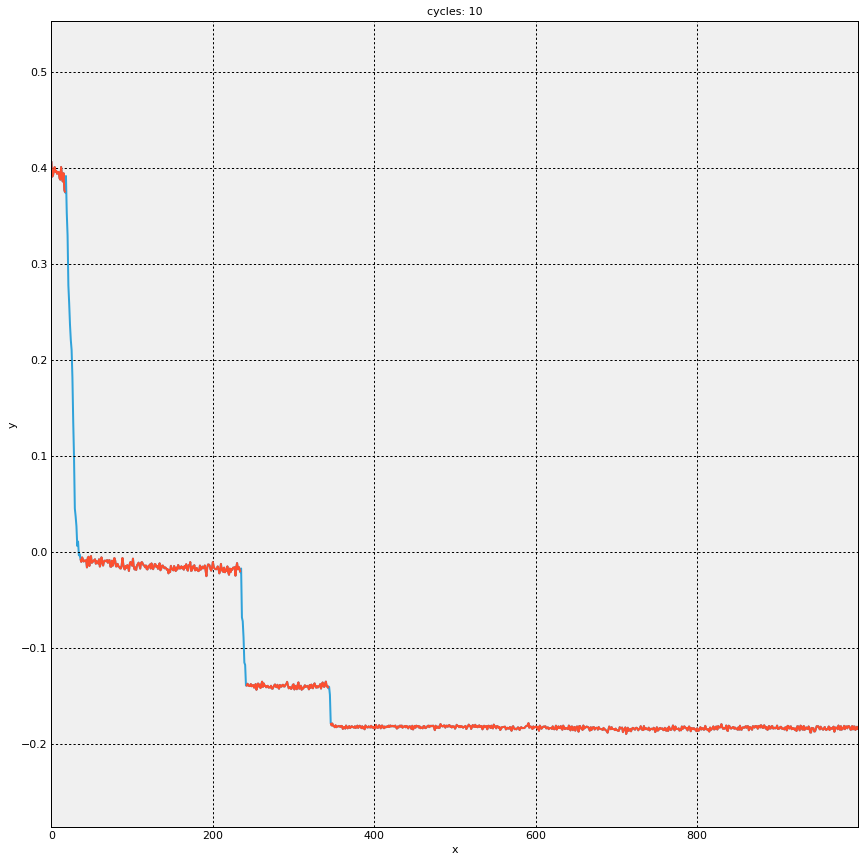
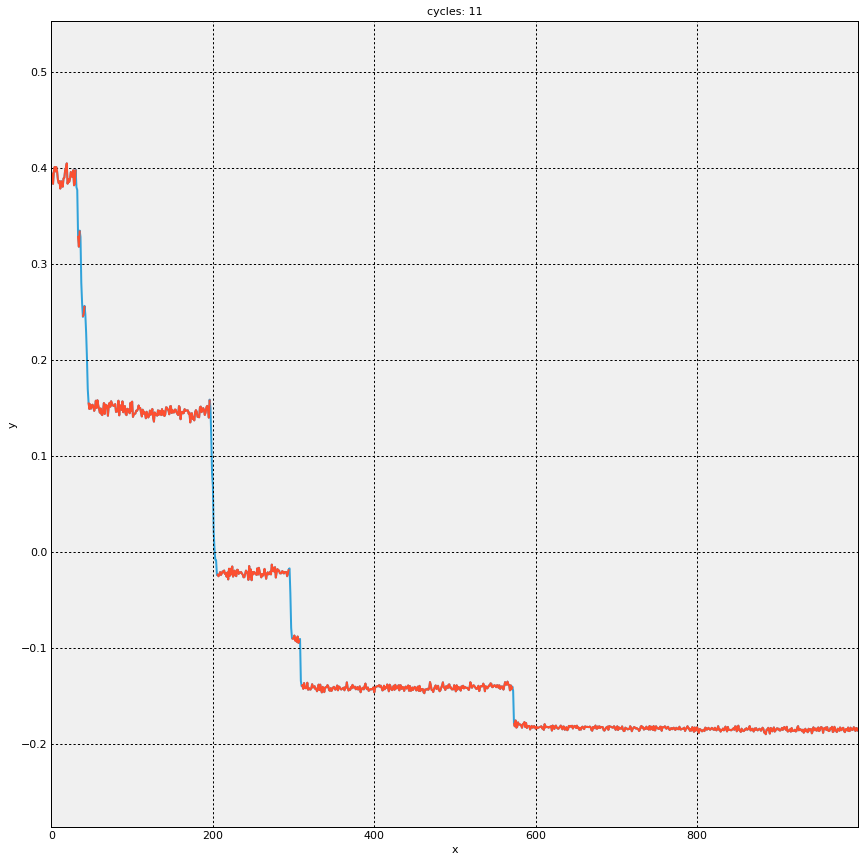
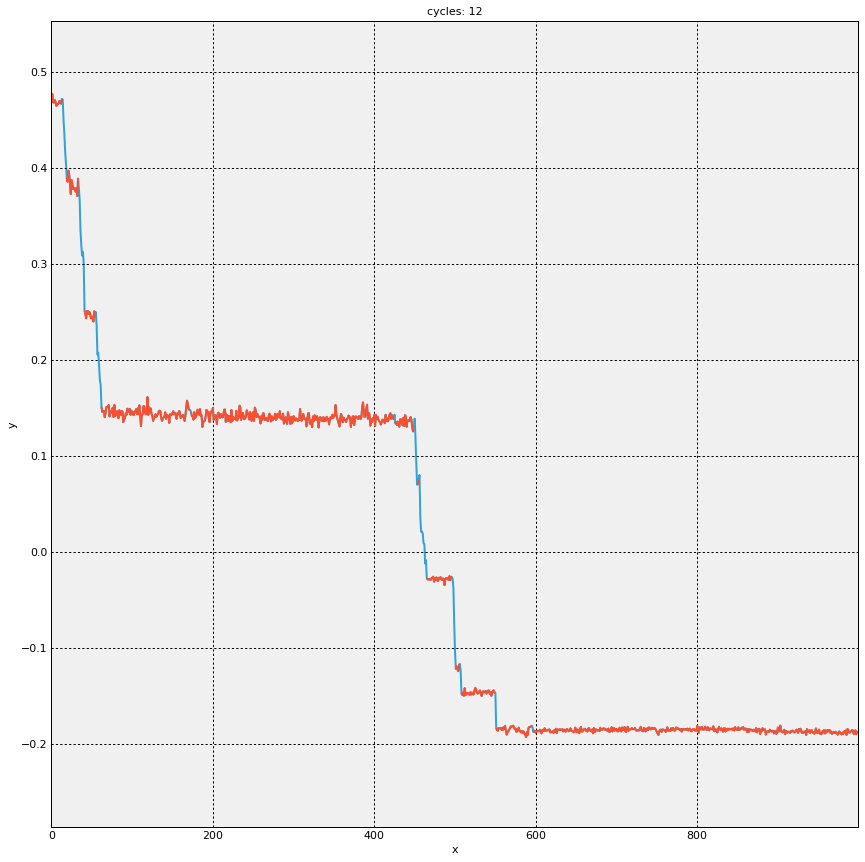
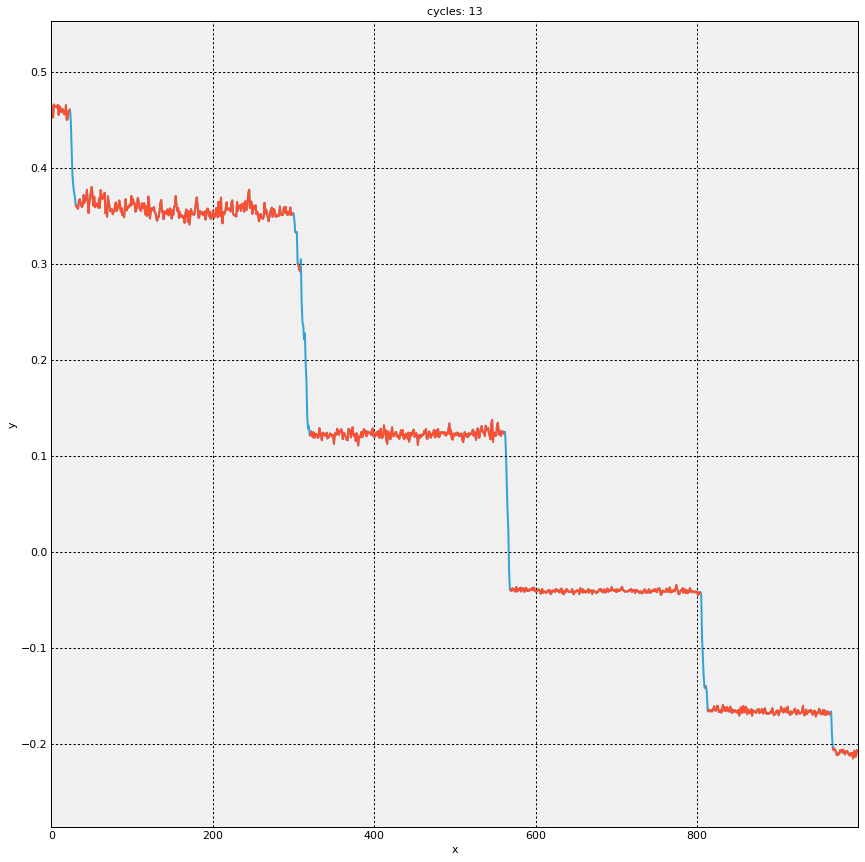
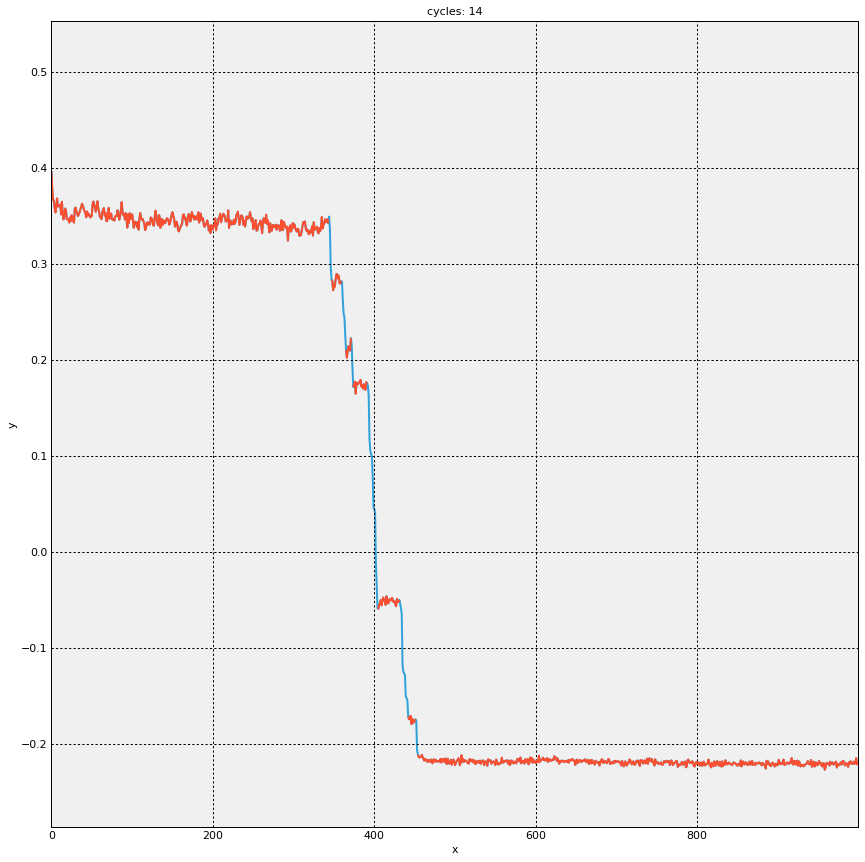
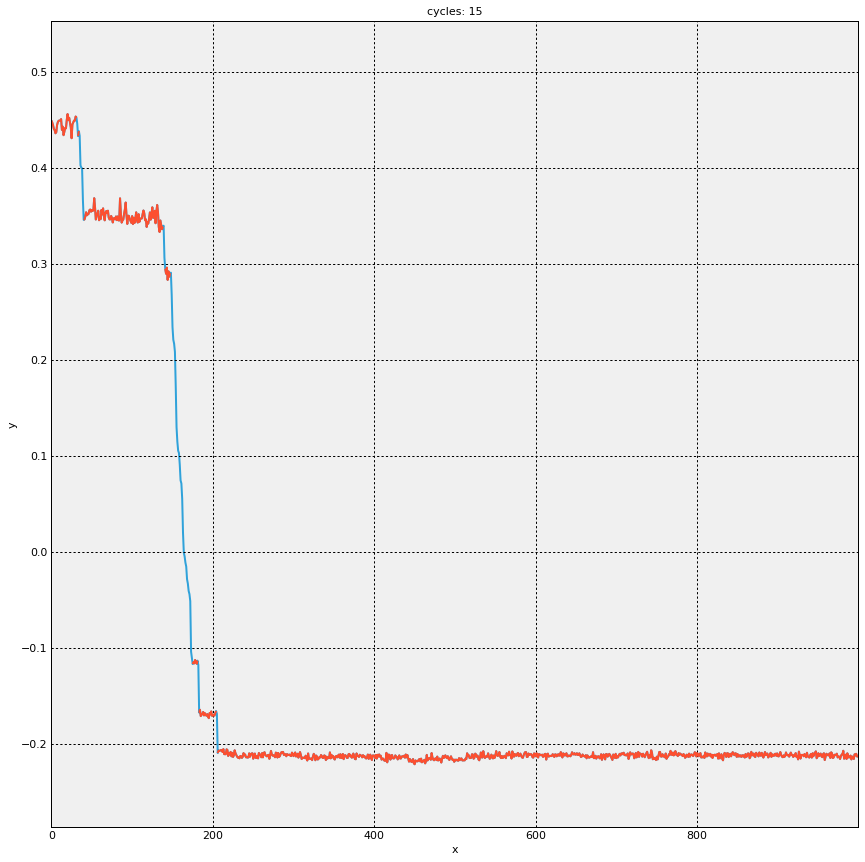
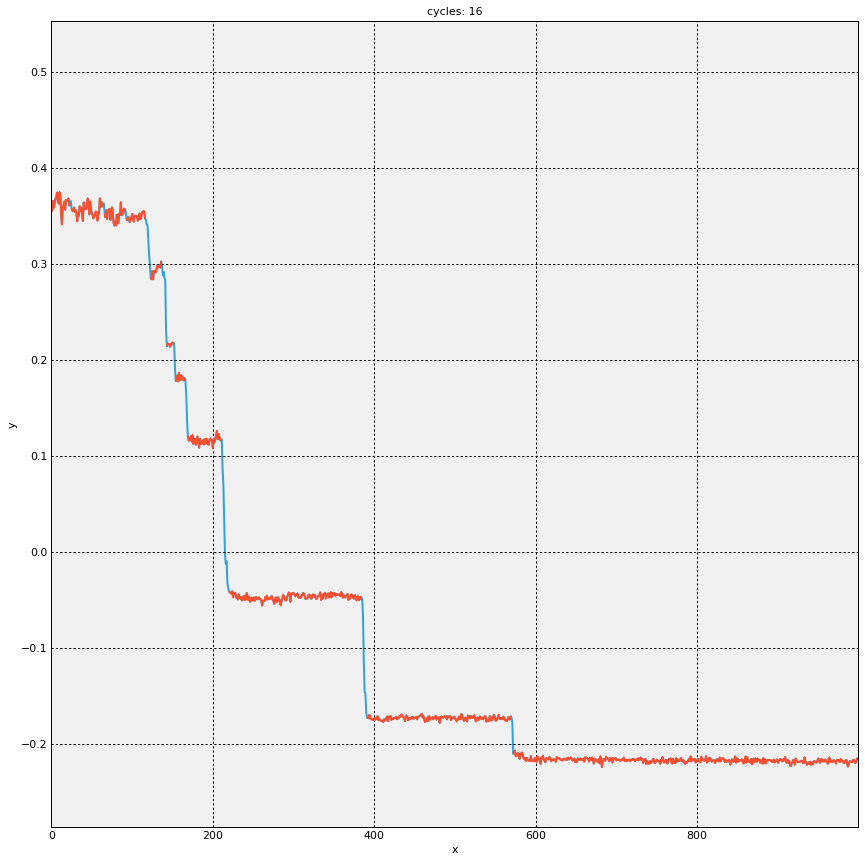
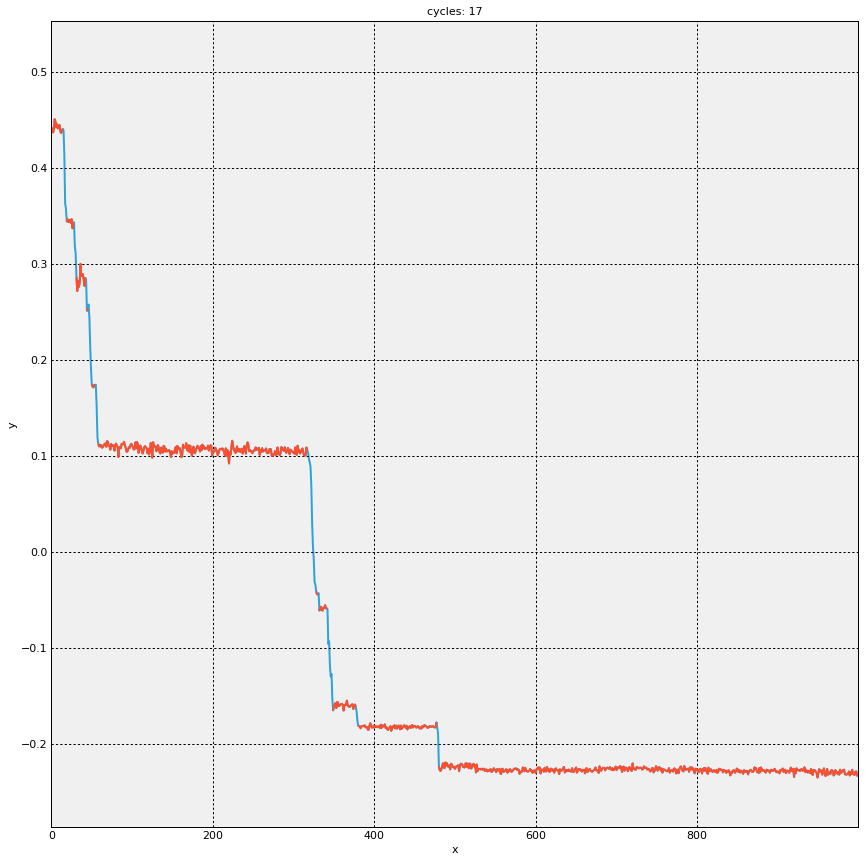
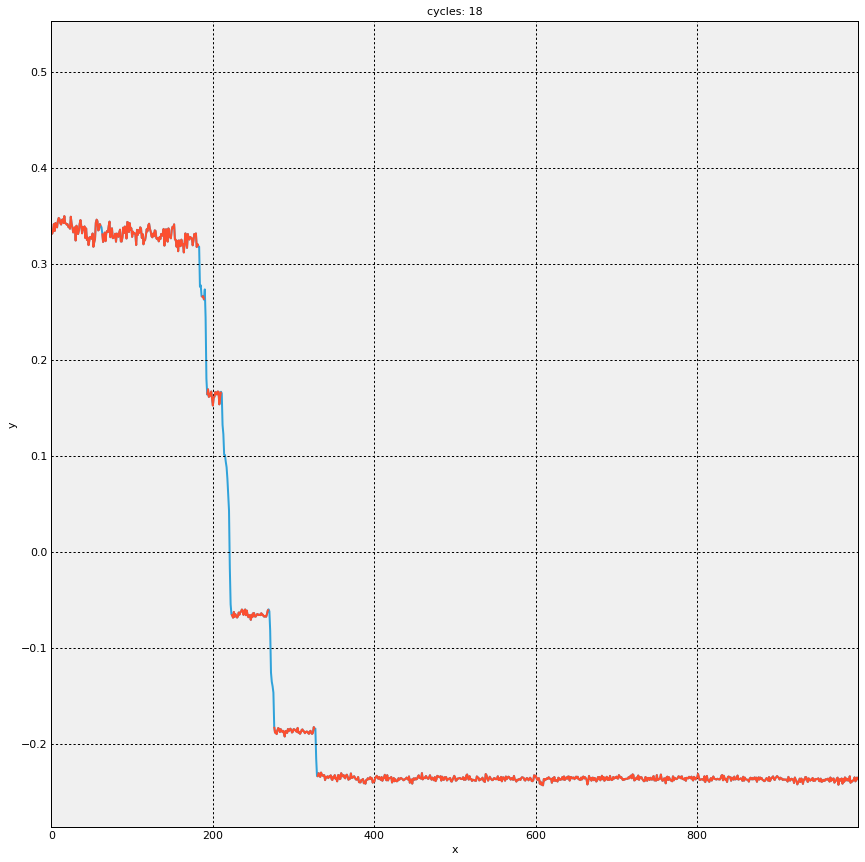
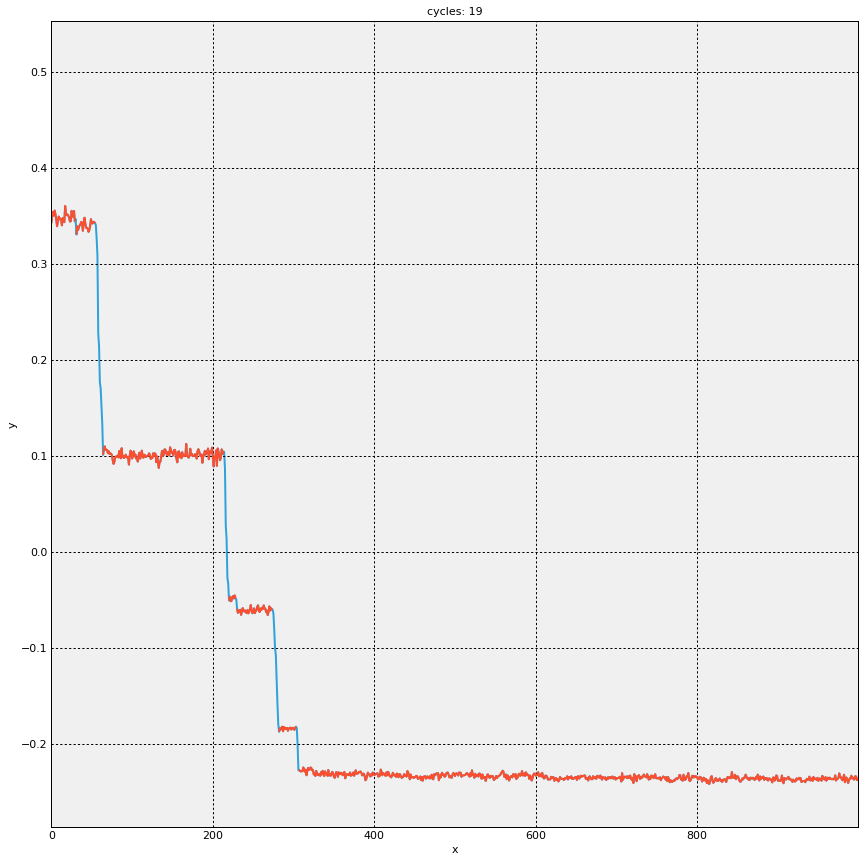
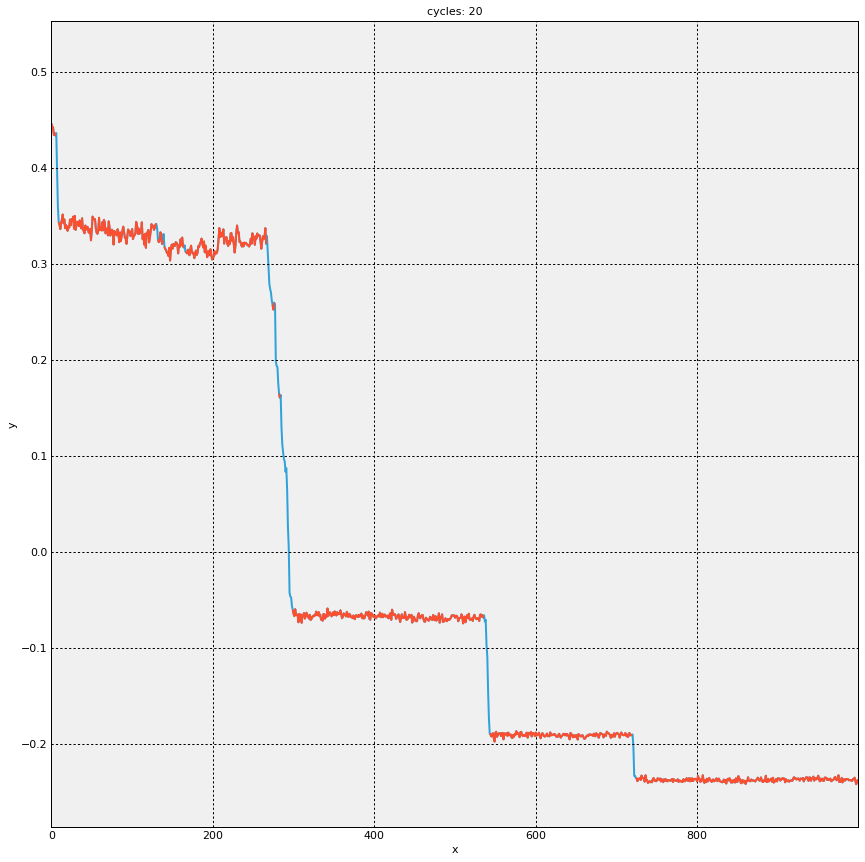
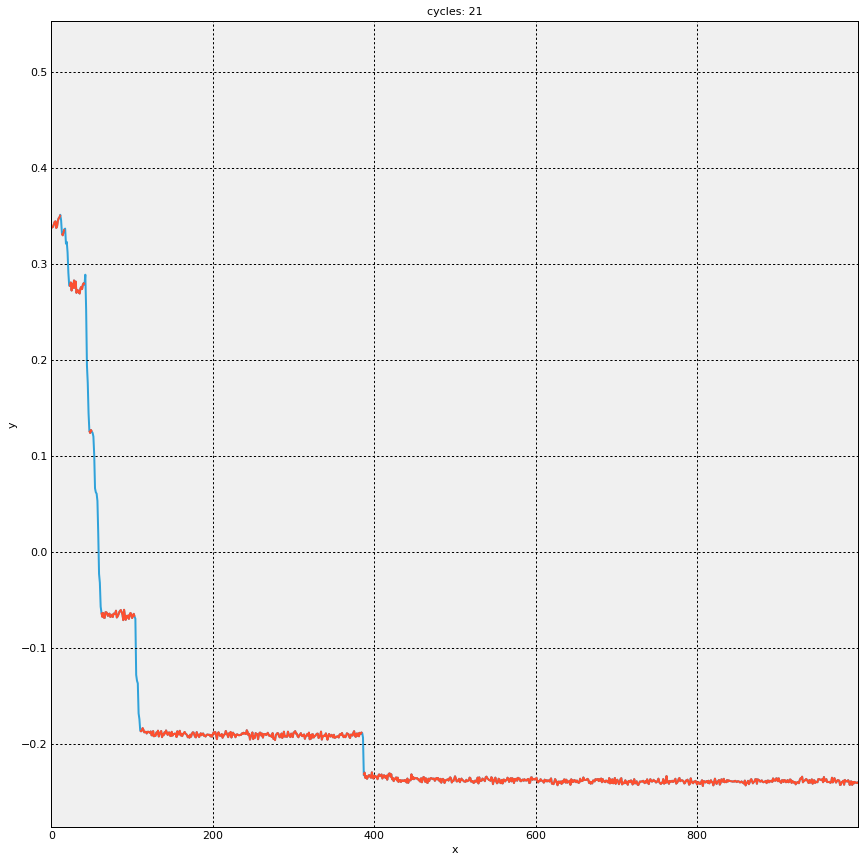
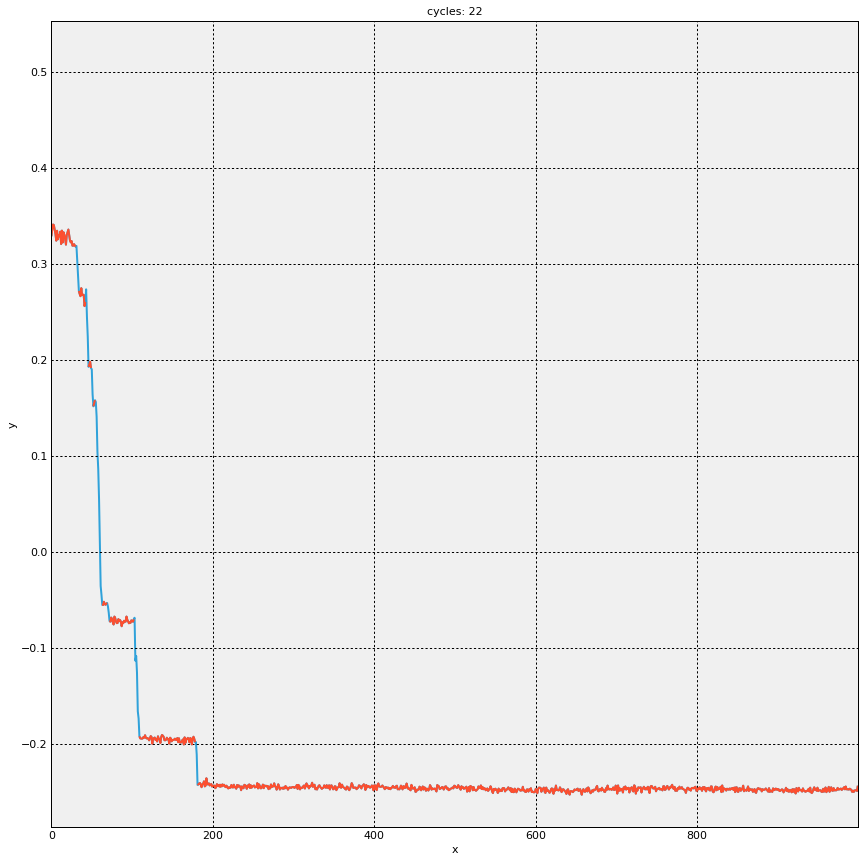
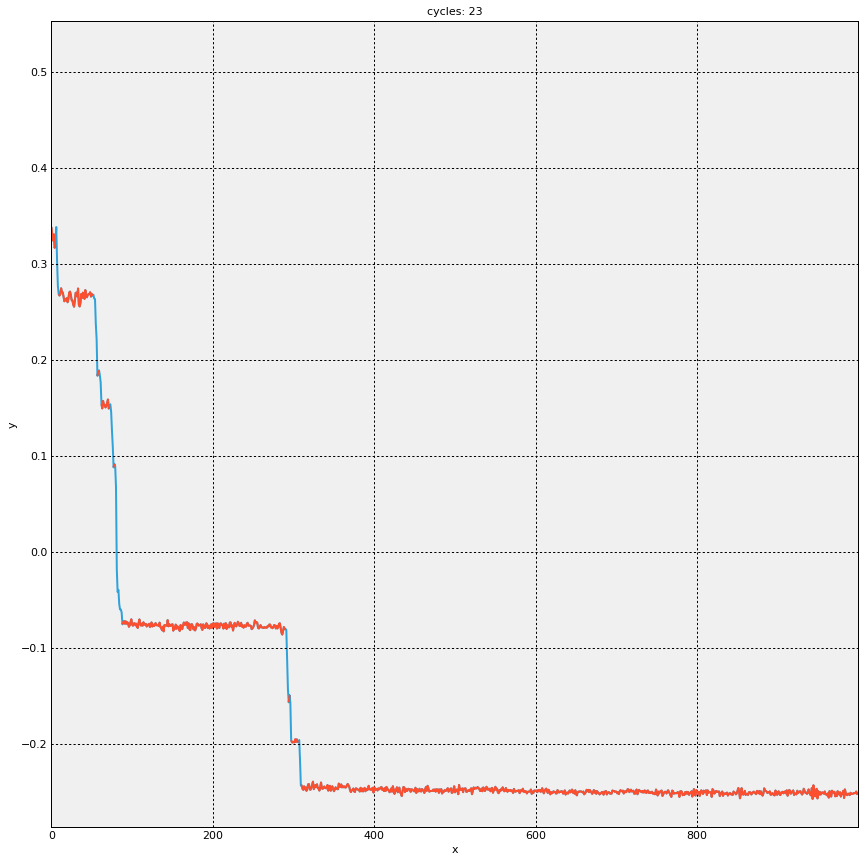
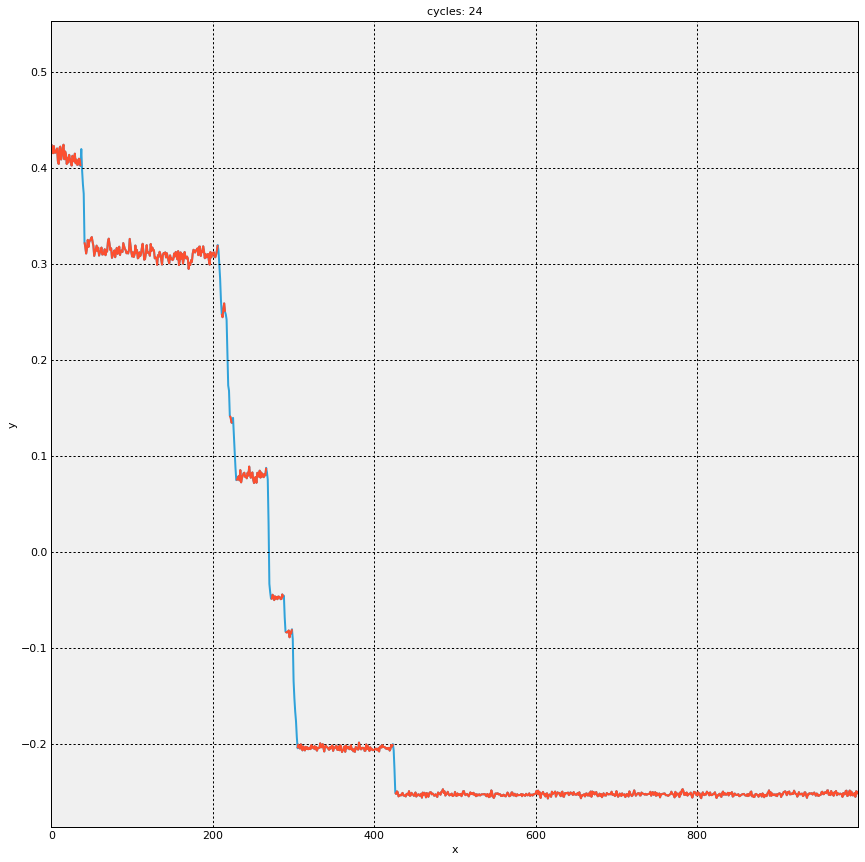
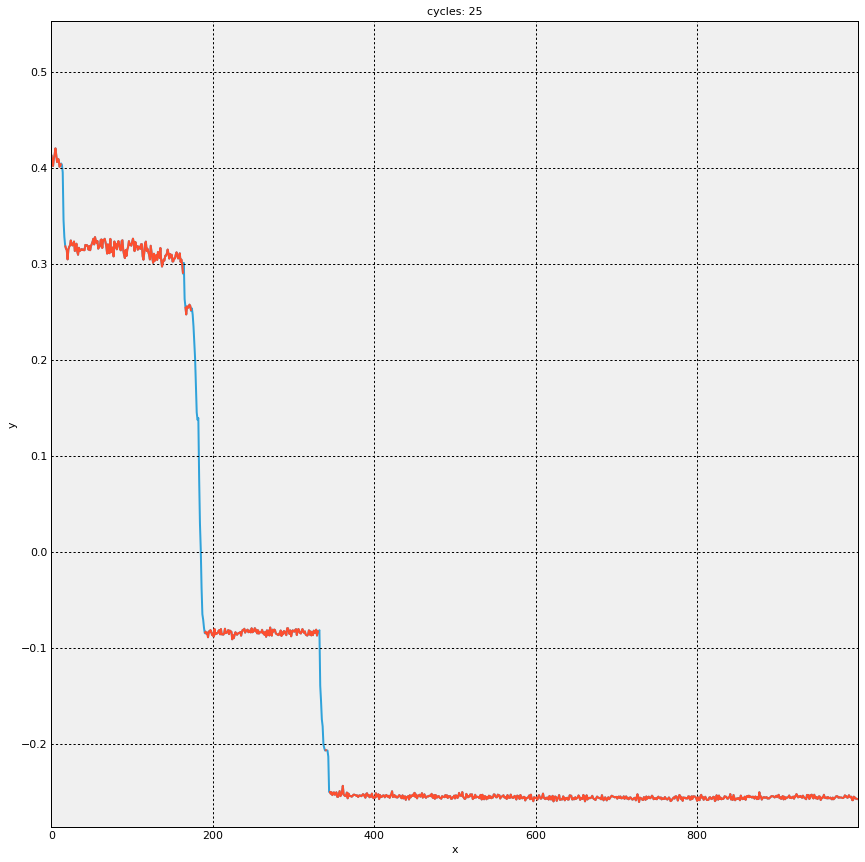
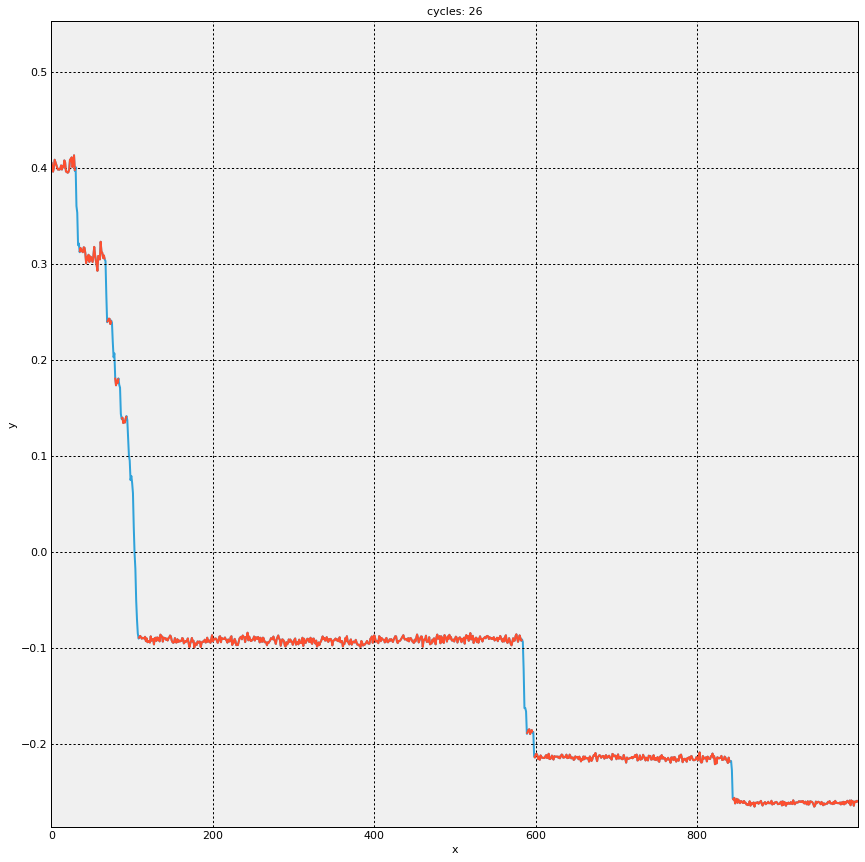
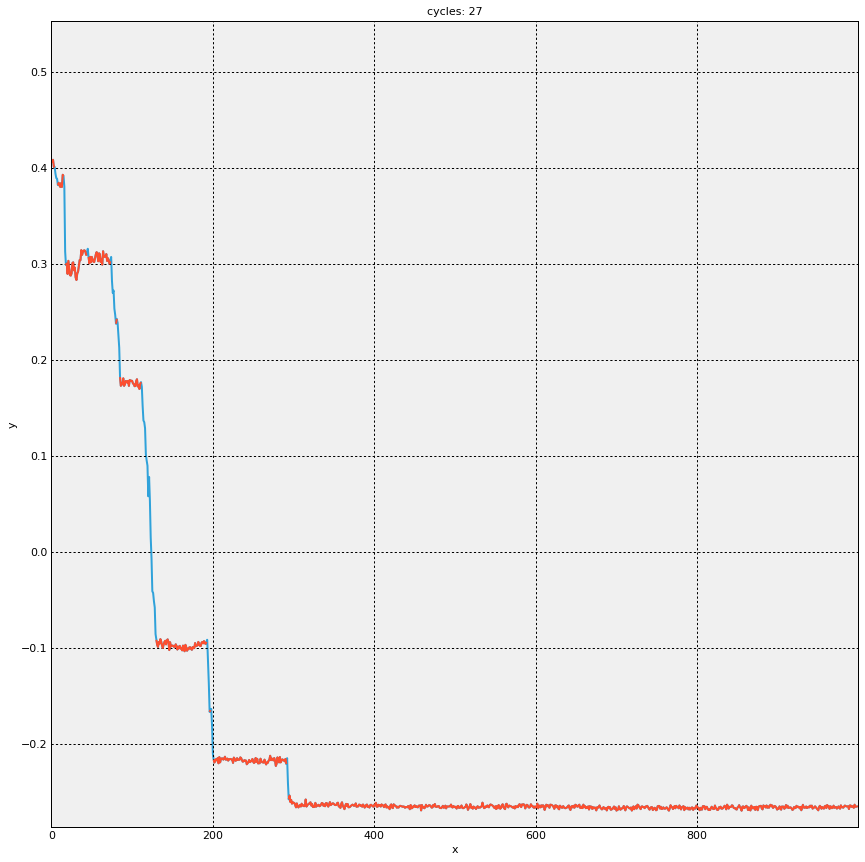
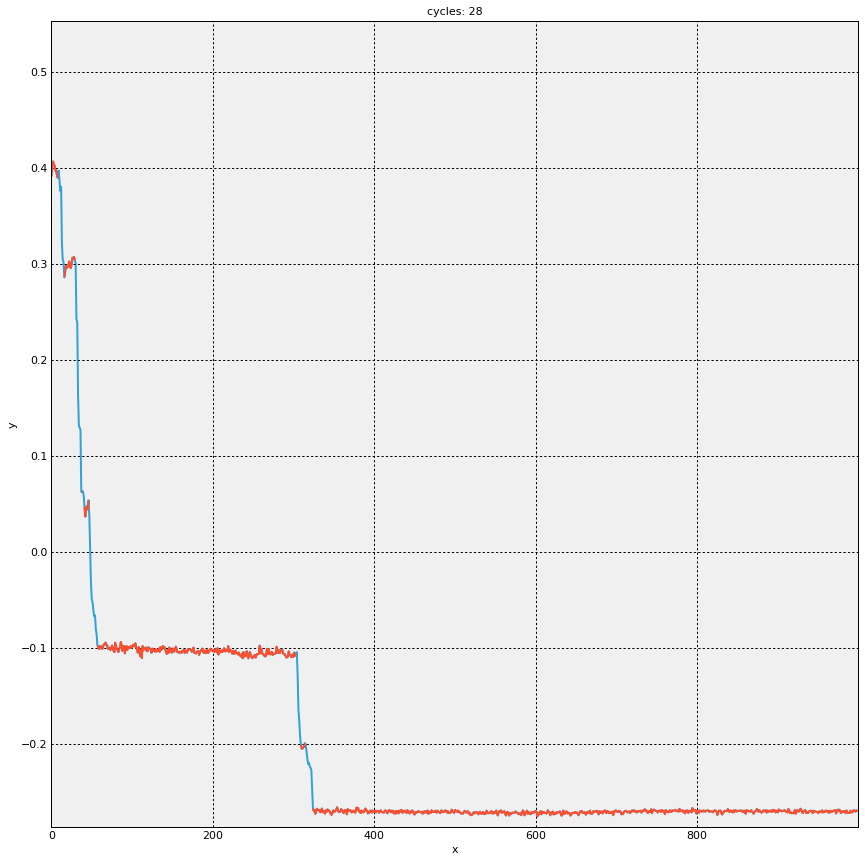
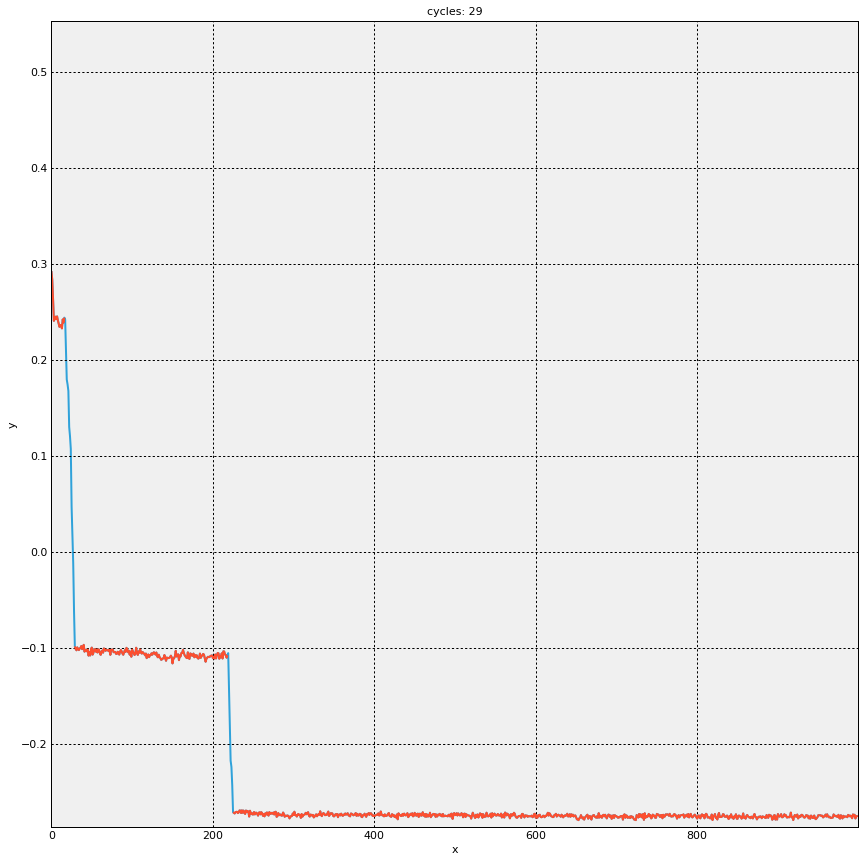
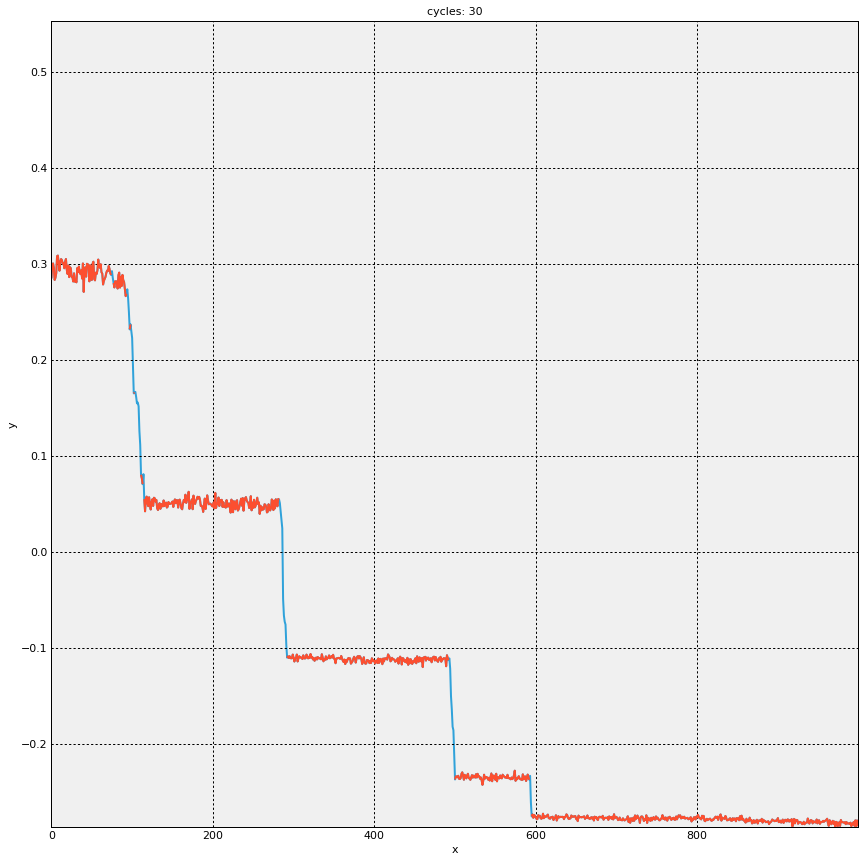
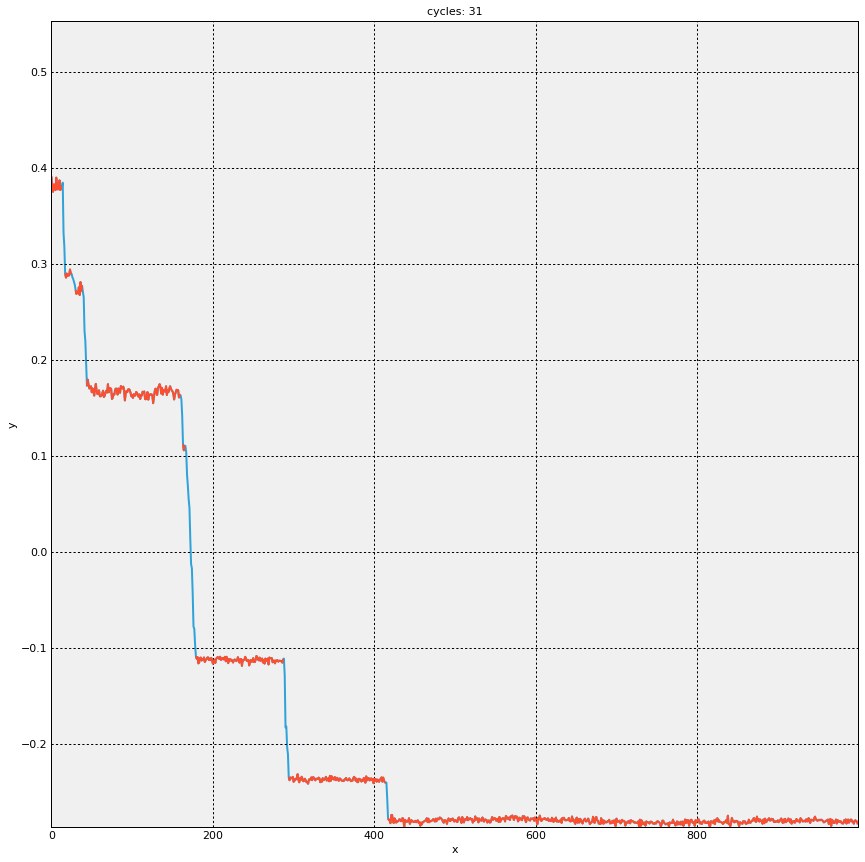

In [33]:
mp = hv.HoloMap(kdims=['cycles'])

mp.update({i[1]: plotter(j) for i, j in measures})
mp